In [1]:
import model_higher_alpha as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats

import torch
import seaborn as sns
from scipy.integrate import simpson

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def log_sum_exp(args):
    if len(args.shape) == 1:
        args = args.unsqueeze(0)
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(NV, DP, a_beta, b_beta):
    return dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(NV) # simply does log(density)

def pareto_lk(mb, NV, DP, alpha):
    LINSPACE = 8000
    alpha_norm = 2
    alpha = alpha * alpha_norm
    x = torch.linspace(mb.pareto_L, mb.pareto_H, LINSPACE)
    y_1 = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(x).exp()
    y_2 = dist.Binomial(probs = x.repeat([NV.shape[0],1]).reshape([LINSPACE,-1]), total_count=DP).log_prob(NV).exp()
    paretobin = torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
    # 1. pareto = simpson((y_1.reshape([LINSPACE, 1]) * y_2).numpy(), x=x.numpy(), axis=0)
    # 1. pareto = torch.tensor(pareto).log()
    # 2. p = BoundedPareto(0.01, alpha, 0.55).sample()
    # 2. paretobin = dist.Binomial(probs=p, total_count=DP).log_prob(data)
    return paretobin

def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        # return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta)).sum()
        return beta_lk(NV, DP, a_beta, b_beta).sum()
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        # return log_sum_exp(pareto_lk(mb, NV, DP, alpha)).sum()
        return pareto_lk(mb, NV, DP, alpha).sum()

def compute_likelihood2(mb, NV, DP, beta = True, dim = 0, k = 0):
    """
    SISTEMA
    """
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta)).sum()
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        return log_sum_exp(pareto_lk(mb, NV, DP, alpha)).sum()

### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [3]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


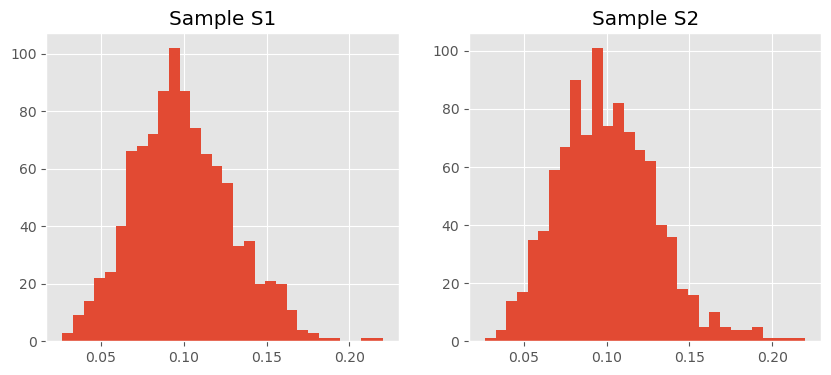

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 30)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 30)
axes[1].set_title("Sample S2")
plt.show()

In [6]:
labels = np.zeros(N1)

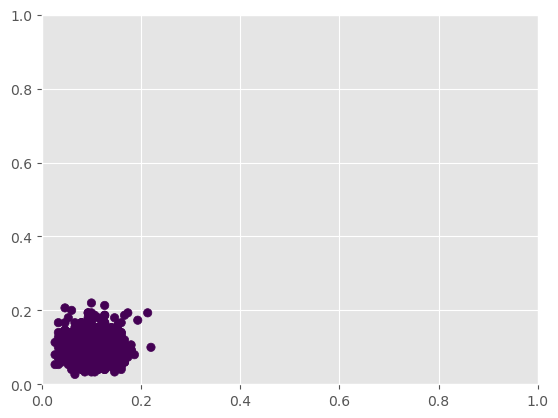

In [7]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
Beta:  tensor([[1.9799, 2.4966]])
Pareto:  tensor([[0.0275, 0.0112]])
Iteration 0: Loss = 7359090.0
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0007, 0.9992]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1369, 0.0909]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 99.8029, 100.2002]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3991, 0.6009],
         [0.3990, 0.6010]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 6722368.0
Iteration 400: Loss = 6449889.0
Iteration 600: Loss = 6362800.5
Iteration 800: Loss = 6270118.0
Iteration 1000: Loss = 6074684.5
Iteration 1200: Loss = 6163164.5
Iteration 1400: Loss = 6125886.0
Iteration 1600: Loss = 6072793.5
Iteration 1800: Loss = 6062221.5
Iteration 2000: Loss = 6040803.0
Iteration 2200: Loss = 6021837.5
Iteration 2400: Loss = 6019796.5
Iteration 2600: Loss = 5933051.0
Iteration 2800: Loss = 6000526.0
Iteration 2999: Loss = 5958357.0
phi_beta [[0.10015611 0.10092009]]


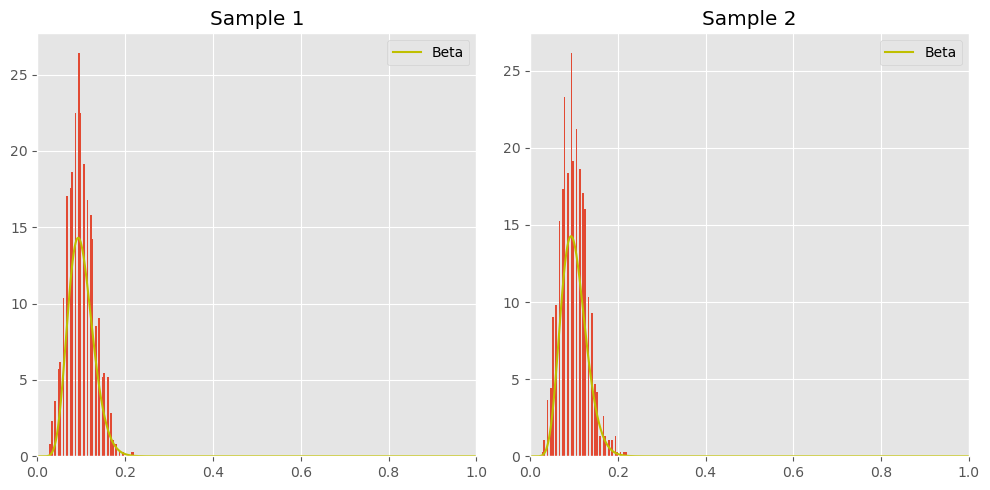

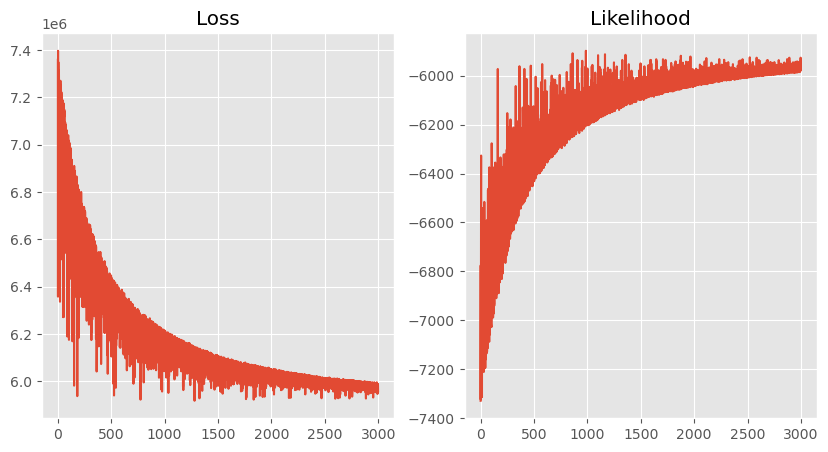

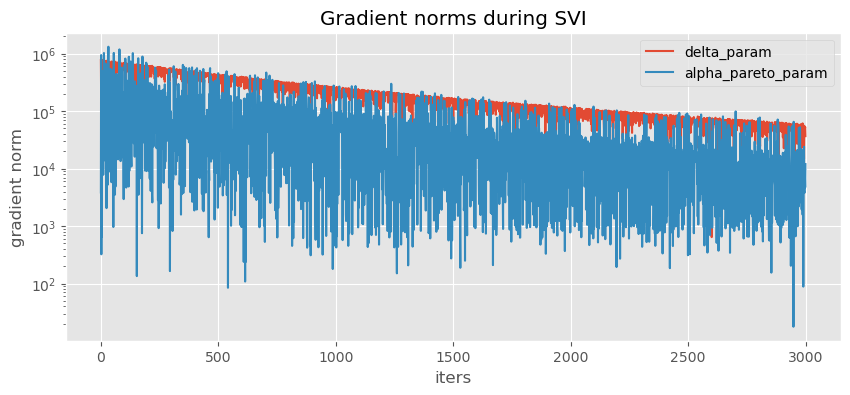

bic:  tensor(25829.3047, grad_fn=<RsubBackward1>)


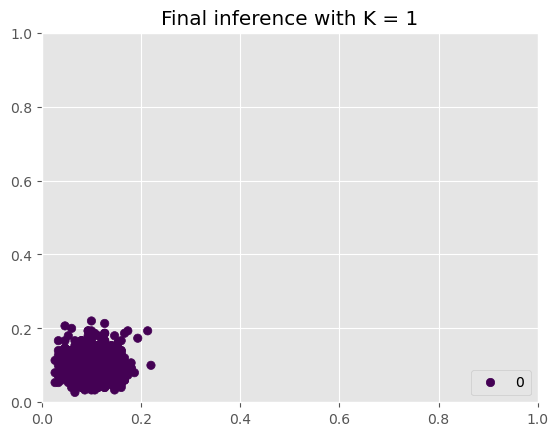

Selected number of clusters is:  1


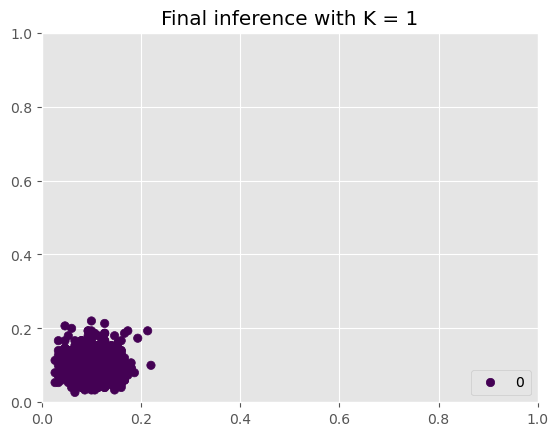

In [9]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1], seed = 53, lr = 0.001)

In [10]:
print(compute_likelihood(final_mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(final_mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 1, k = 0))

tensor(-2964.3940, grad_fn=<SumBackward0>)
tensor(-4440.6348, grad_fn=<SumBackward0>)
tensor(-2960.4233, grad_fn=<SumBackward0>)
tensor(-4433.6860, grad_fn=<SumBackward0>)


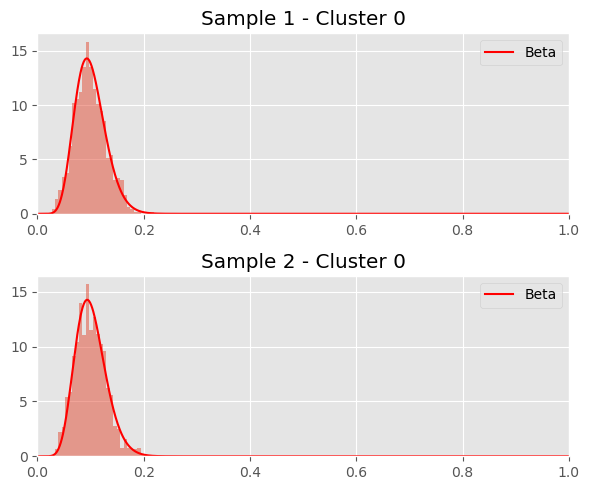

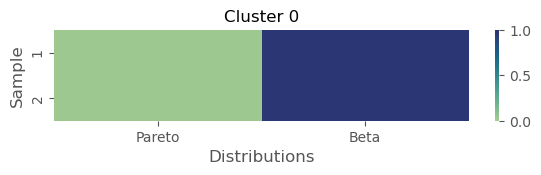

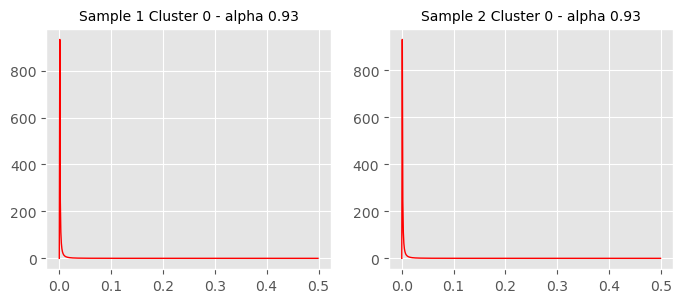

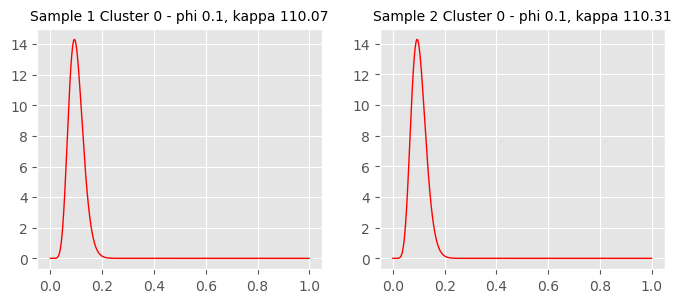

In [47]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [40]:
final_mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[0.9326, 0.9321]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1002, 0.1009]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[110.0685, 110.3067]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0304, 0.9696],
          [0.0309, 0.9691]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### One pareto-pareto component

In [5]:
N1 = 1000
seed = 123

alpha_pareto_x = 1.2
alpha_pareto_y = 1.4
scale = 0.01
upper_bound = 0.5
n1=100
NV, DP = only_pareto_binomial_component(alpha_x=alpha_pareto_x, L_x=scale, H_x=upper_bound, alpha_y=alpha_pareto_y, L_y=scale, 
                                        H_y=upper_bound, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


In [8]:
# alpha = alpha_pareto_x
# pareto_mean = alpha*scale/(alpha-1)
# print(pareto_mean)
# dim = 0
# print("Pareto lk: ", pareto_lk(NV[:, dim], DP[:, dim], alpha).sum())
# phi_beta = pareto_mean
# k_beta = torch.tensor(150.)
# a_beta = phi_beta * k_beta
# b_beta = (1-phi_beta) * k_beta
# print("Beta lk: ", beta_lk(NV[:, dim], DP[:, dim], a_beta, b_beta).sum())

# dim = 1
# print("Pareto lk: ", pareto_lk(NV[:, dim], DP[:, dim], alpha).sum())
# phi_beta = pareto_mean
# k_beta = torch.tensor(150.)
# a_beta = phi_beta * k_beta
# b_beta = (1-phi_beta) * k_beta
# print("Beta lk: ", beta_lk(NV[:, dim], DP[:, dim], a_beta, b_beta).sum())

In [9]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0100)
tensor(0.0100)


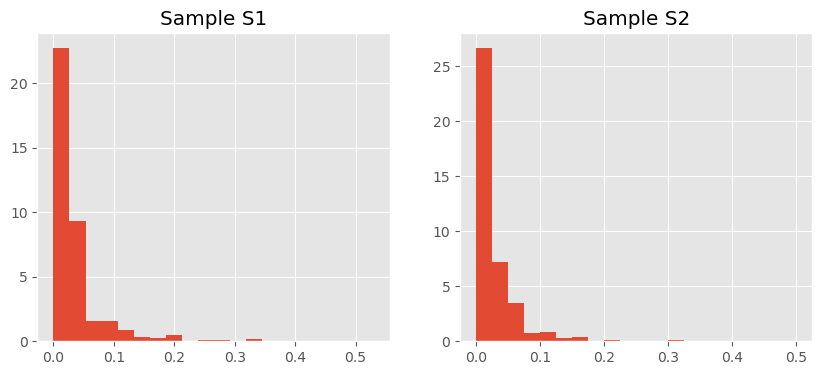

In [10]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [11]:
labels = np.zeros(N1)

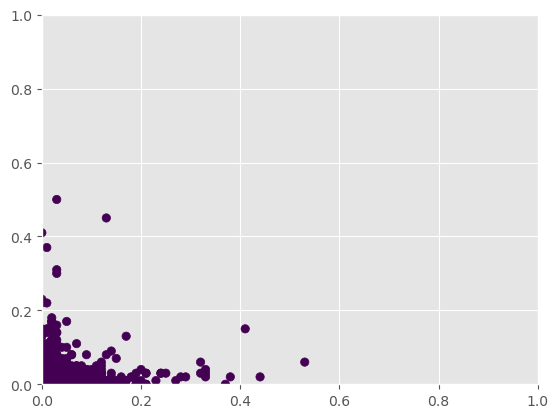

In [12]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
NV = 0 before: tensor(345)
NV = 0 after: tensor(0)
Beta:  tensor([[3.3755, 3.1793]])
Pareto:  tensor([[2.0190, 2.4463]])
Iteration 0: Loss = 5289978.5
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9992, 1.0007]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1000, 0.1000]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6015, 199.6005]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.4010, 0.5990],
         [0.4010, 0.5990]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 4983798.0
Iteration 400: Loss = 4913858.5
Iteration 600: Loss = 5473967.0
Iteration 800: Loss = 4811101.0
Iteration 1000: Loss = 4787205.5
Iteration 1200: Loss = 4683313.0
Iteration 1400: Loss = 9364917.0
Iteration 1600: Loss = 4687082.5
Iteration 1800: Loss = 4924210.0
Iteration 2000: Loss = 4876168.5
Iteration 2200: Loss = 4696790.5
Iteration 2400: Loss = 4745989.0
Iteration 2600: Loss = 4569902.5
Iteration 2800: Loss = 4912397.5
Iteration 2999: Loss = 45984

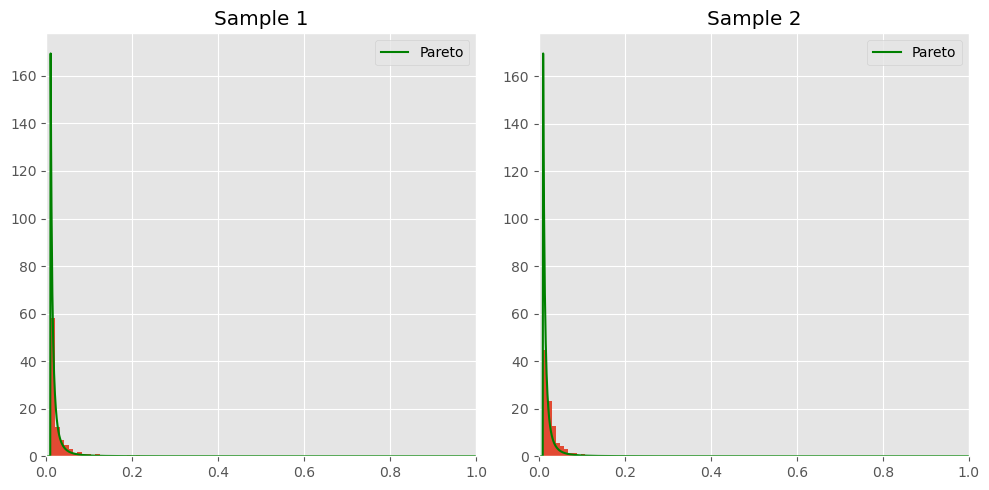

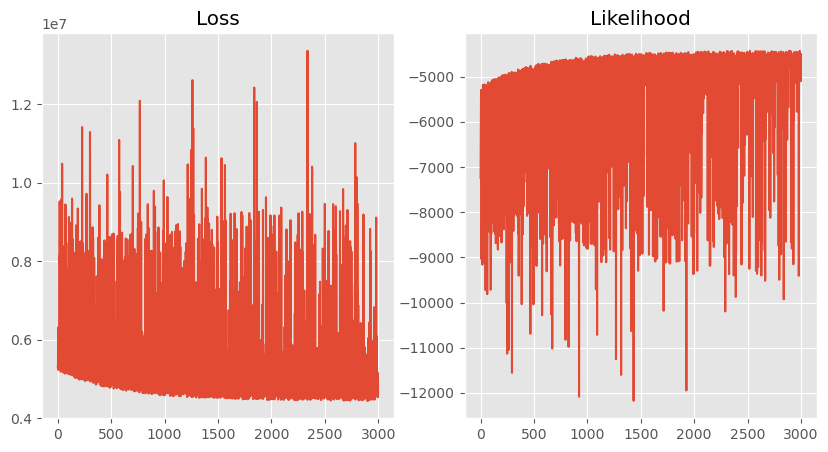

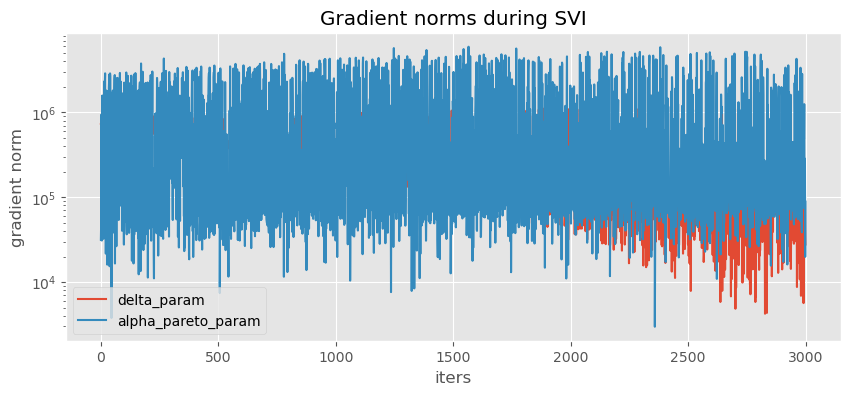

bic:  tensor(32071.1250, grad_fn=<RsubBackward1>)


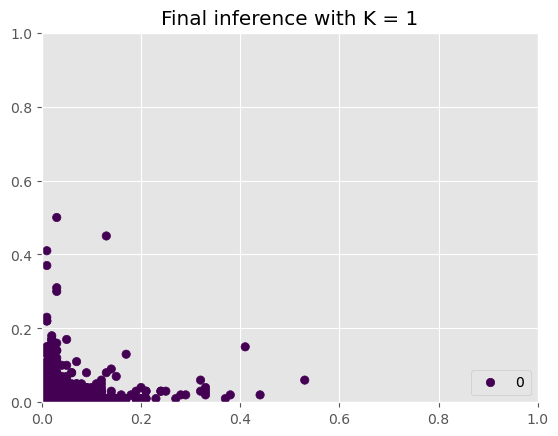

Selected number of clusters is:  1


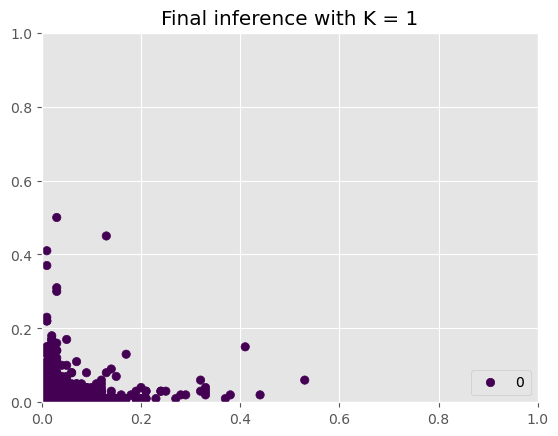

In [13]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1], seed = 12, lr = 0.001)

In [21]:
print(compute_likelihood(final_mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(final_mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(final_mb, beta = False, dim = 1, k = 0))

tensor(-5121.3950, grad_fn=<SumBackward0>)
tensor(-4533.4258, grad_fn=<SumBackward0>)
tensor(-5233.3687, grad_fn=<SumBackward0>)
tensor(-4607.0996, grad_fn=<SumBackward0>)


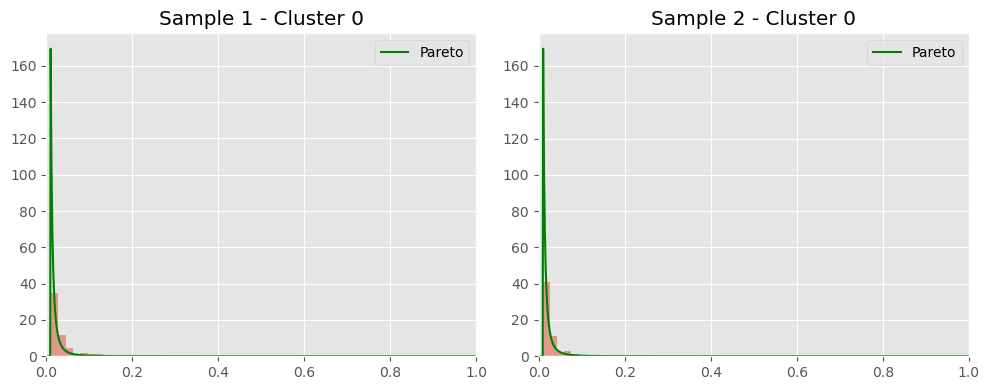

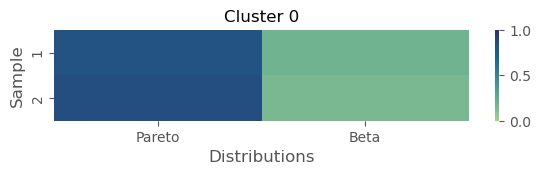

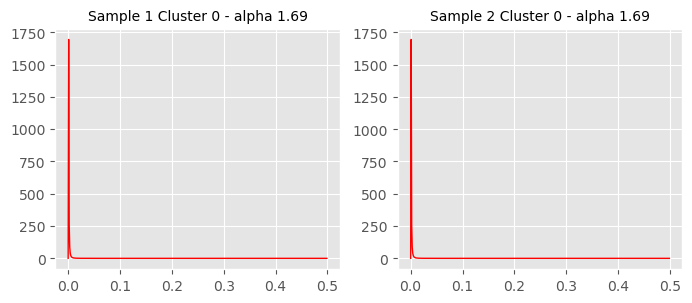

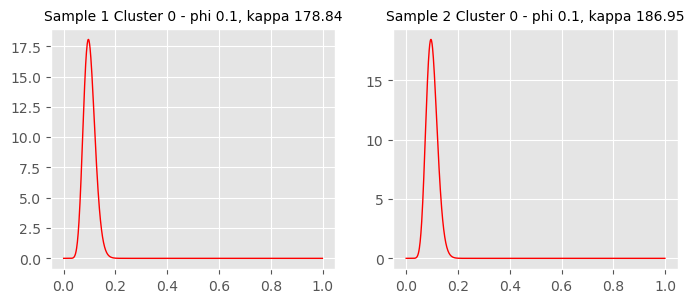

In [15]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [16]:
final_mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.6941, 1.6949]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[178.8440, 186.9473]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8100, 0.1900],
          [0.8451, 0.1549]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### One beta-pareto component

In [20]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 1
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

In [21]:
alpha = alpha_pareto
# pareto_mean = alpha*scale/(alpha-1)
print(pareto_mean)
dim = 0
print("Pareto lk: ", pareto_lk(NV[:, dim], DP[:, dim], alpha).sum())
# phi_beta_x = pareto_mean
phi_beta_x = 0.01
k_beta_x = torch.tensor(150.)
a_beta = phi_beta_x * k_beta_x
b_beta = (1-phi_beta_x) * k_beta_x
print("Beta lk: ", beta_lk(NV[:, dim], DP[:, dim], a_beta, b_beta).sum())

dim = 1
print("Pareto lk: ", pareto_lk(NV[:, dim], DP[:, dim], alpha).sum())
a_beta = phi_beta * k_beta
b_beta = (1-phi_beta) * k_beta
print("Beta lk: ", beta_lk(NV[:, dim], DP[:, dim], a_beta, b_beta).sum())

0.06000000000000001
Pareto lk:  tensor(-4707.0005)
Beta lk:  tensor(-4007.3467)
Pareto lk:  tensor(-3995.8521)
Beta lk:  tensor(-2678.9717)


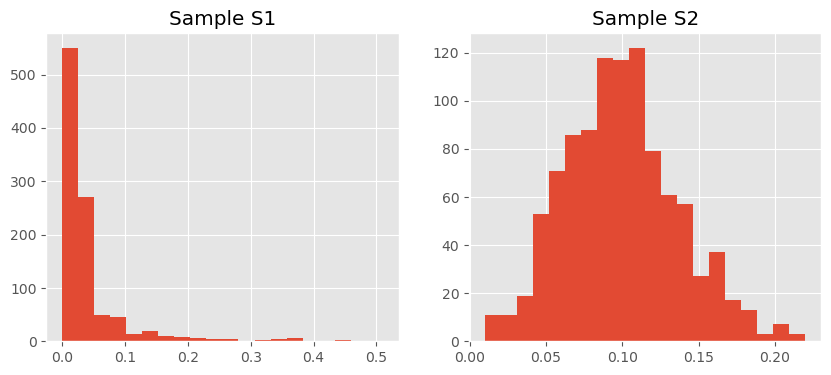

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [23]:
labels = np.zeros(N1)

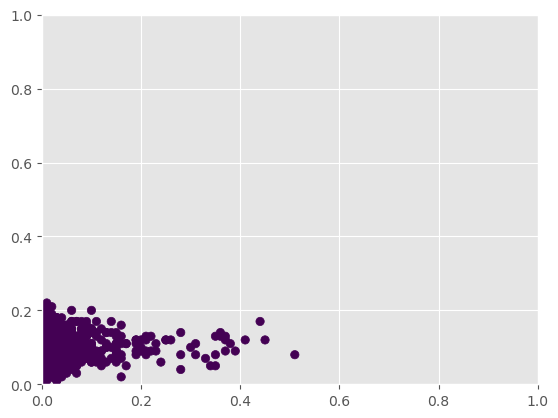

In [24]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  1
NV = 0 before: tensor(161)
NV = 0 after: tensor(0)
Beta:  tensor([[3.2443, 2.9315]])
Pareto:  tensor([[ 1.6945, -0.0036]])
Iteration 0: Loss = 6043374.5
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9993, 0.9993]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1000, 0.1036]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6339, 200.3958]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3995, 0.6005],
         [0.3991, 0.6009]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 7236131.0
Iteration 400: Loss = 5855261.0
Iteration 600: Loss = 5565681.5
Iteration 800: Loss = 5391843.0
Iteration 1000: Loss = 5532282.5
Iteration 1200: Loss = 5343550.5
Iteration 1400: Loss = 5460701.0
Iteration 1600: Loss = 5394377.0
Iteration 1800: Loss = 5303715.5
Iteration 2000: Loss = 5386699.0
Iteration 2200: Loss = 5451676.0
Iteration 2400: Loss = 5342212.0
Iteration 2600: Loss = 5307139.5
Iteration 2800: Loss = 5523943.0
Iteration 2999: Loss = 896

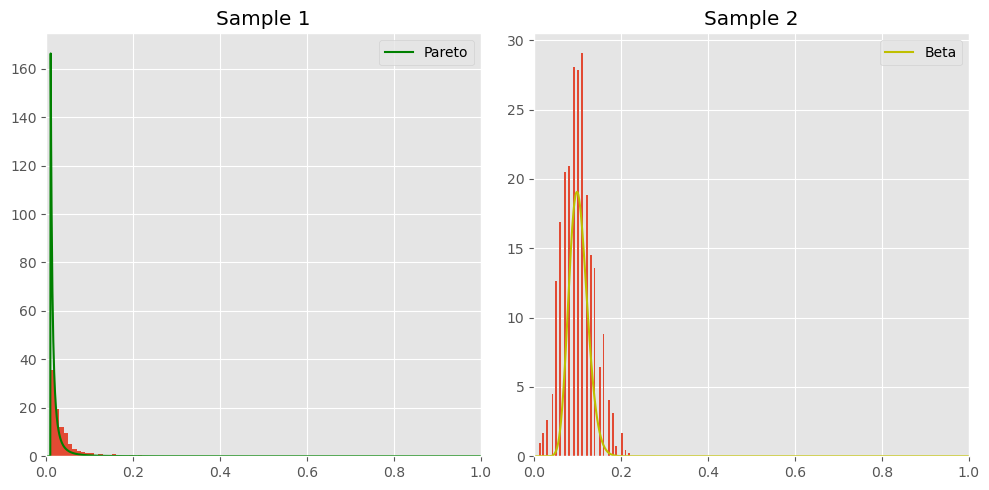

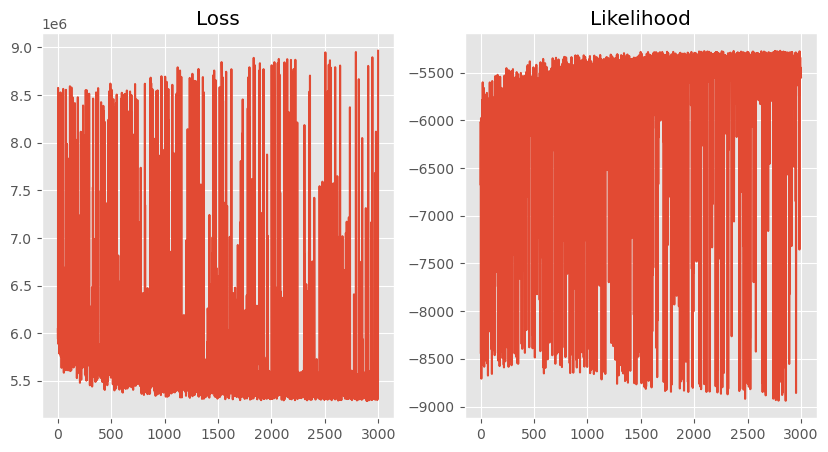

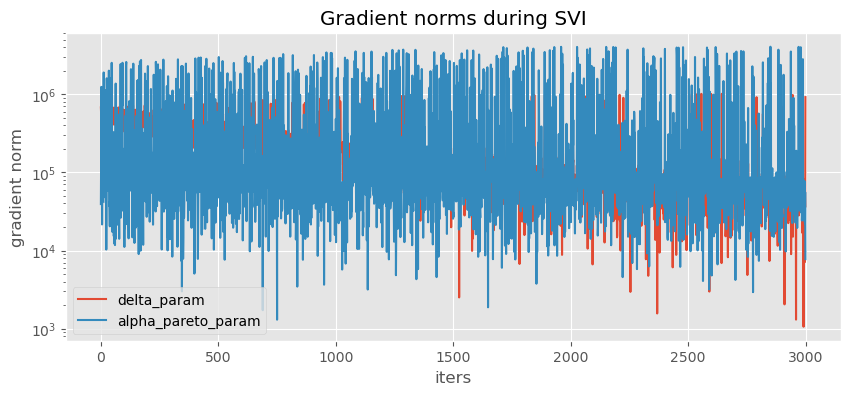

bic:  tensor(28119.4570, grad_fn=<RsubBackward1>)


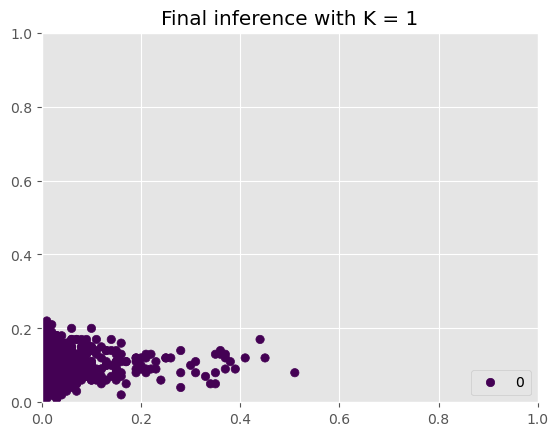

Selected number of clusters is:  1


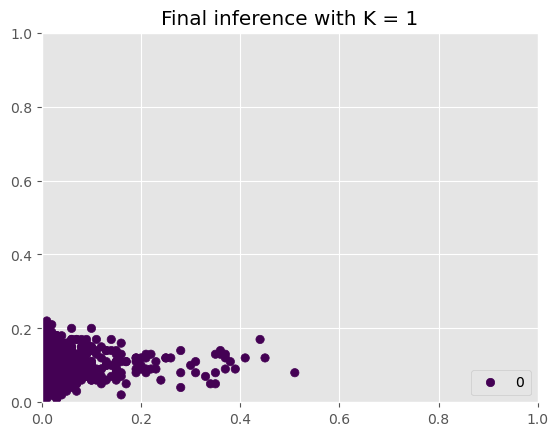

In [25]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [1], seed = 15, lr = 0.001)

In [26]:
print(compute_likelihood(final_mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(final_mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(final_mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(final_mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(-5343.3521, grad_fn=<SumBackward0>)
tensor(-4686.8936, grad_fn=<SumBackward0>)
tensor(-2679.9253, grad_fn=<SumBackward0>)
tensor(-3970.9961, grad_fn=<SumBackward0>)


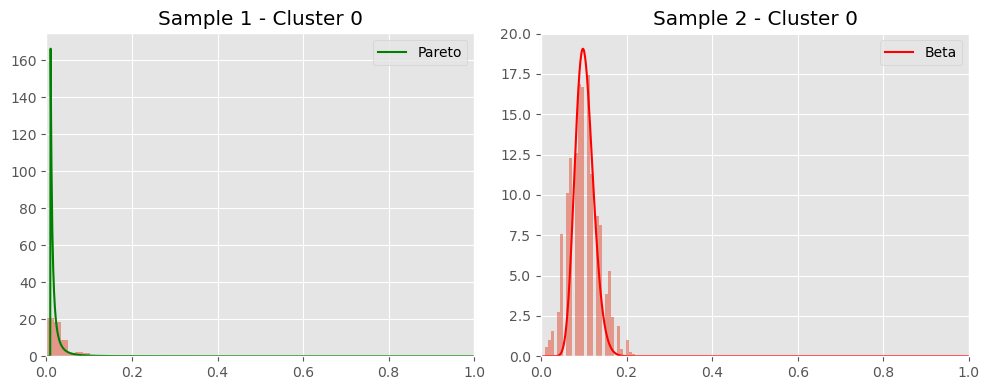

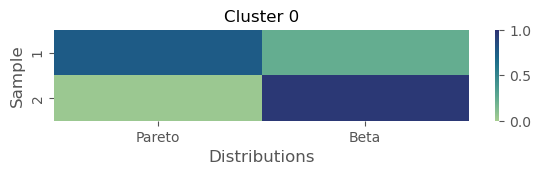

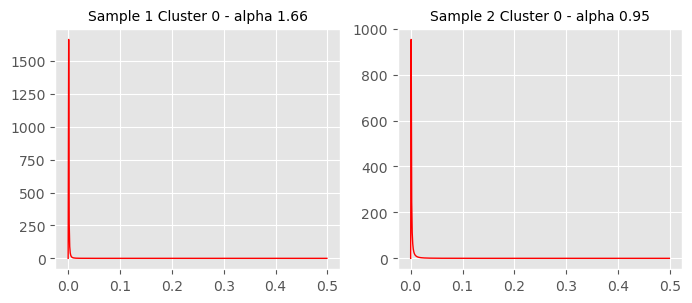

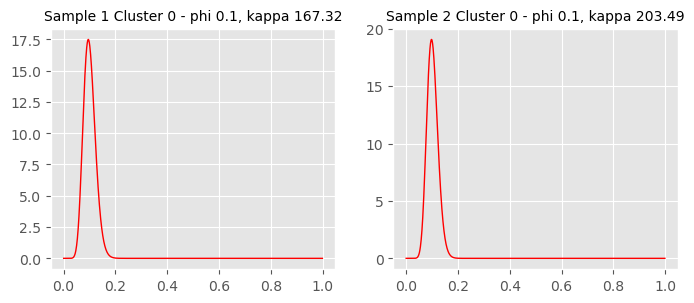

In [27]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [28]:
final_mb.params

{'weights_param': tensor([1.], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.6629, 0.9533]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.1019]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[167.3188, 203.4936]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.7635, 0.2365],
          [0.0359, 0.9641]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.

### 2 beta-pareto components

In [110]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 1.5
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.2
k_beta = 100
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


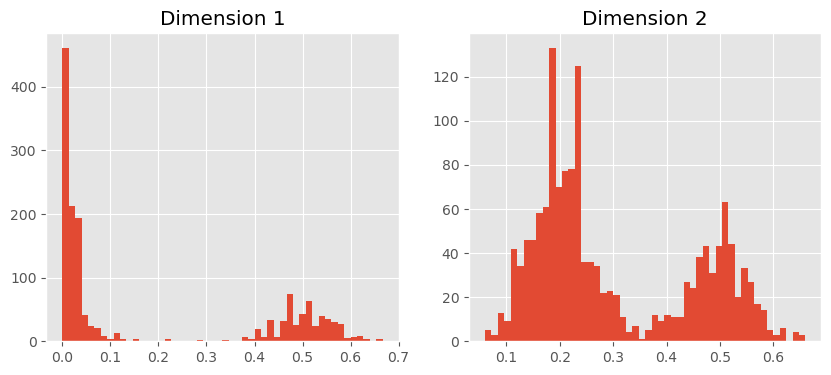

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [112]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

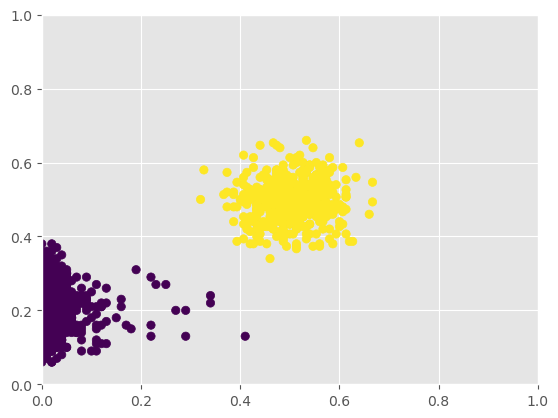

In [113]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K =  2
NV = 0 before: tensor(199)
NV = 0 after: tensor(0)
Beta:  tensor([[3.4143, 2.6391],
        [2.4193, 2.4140]])
Pareto:  tensor([[ 2.6184, -1.4104],
        [-3.2294, -3.2061]])
Iteration 0: Loss = 21474330.0
weights_param tensor([0.7135, 0.2865], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0007, 0.9993],
        [1.0008, 0.9991]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1000, 0.2056],
        [0.5000, 0.5013]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6398, 199.6406],
        [199.6026, 199.6142]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.4005, 0.5995],
         [0.3990, 0.6010]],

        [[0.3990, 0.6010],
         [0.3990, 0.6010]]], grad_fn=<DivBackward0>)
Iteration 200: Loss = 16233632.0
Iteration 400: Loss = 15704629.0
Iteration 600: Loss = 15433545.0
Iteration 800: Loss = 16719301.0
Iteration 1000: Loss = 14934869.0
Iteration 1200: Loss = 15157684.0
Iteration 1400: Loss = 14832494.0
Iteration 1600: Loss = 20055168.0
Iteration 1

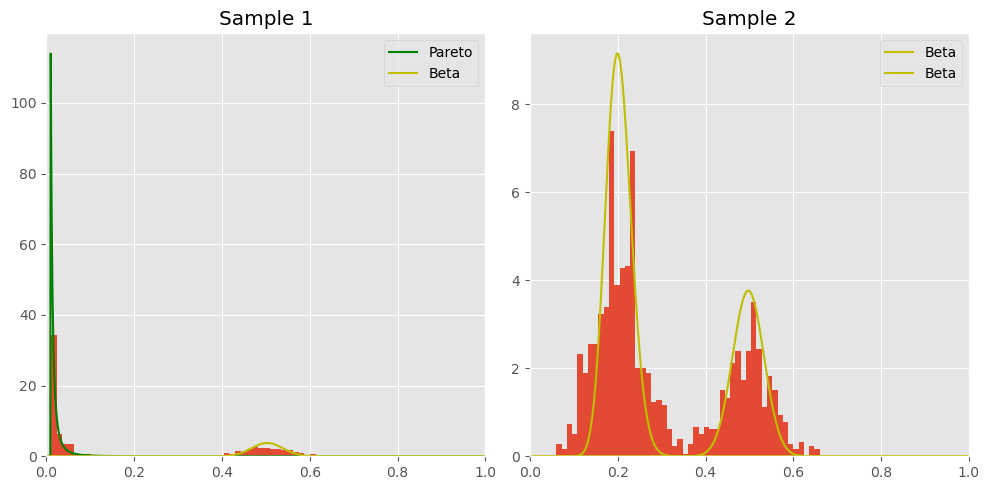

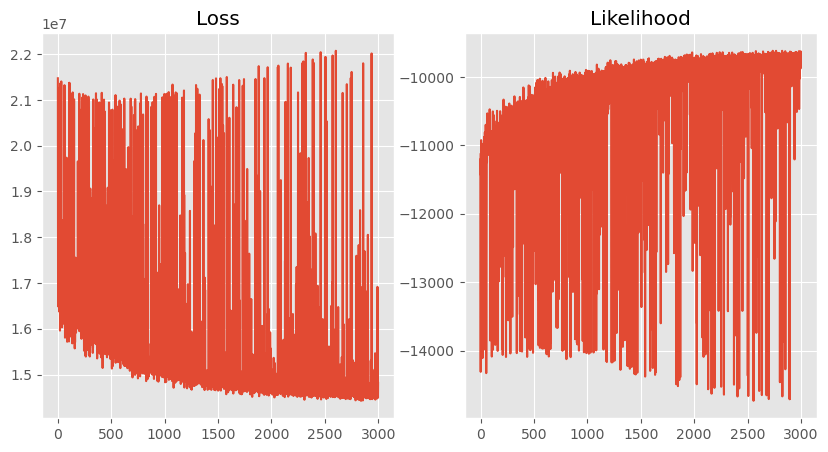

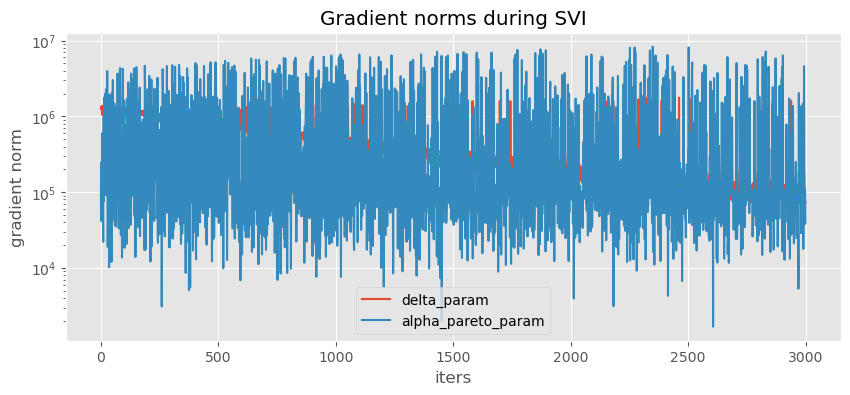

bic:  tensor(56818.3945, grad_fn=<RsubBackward1>)


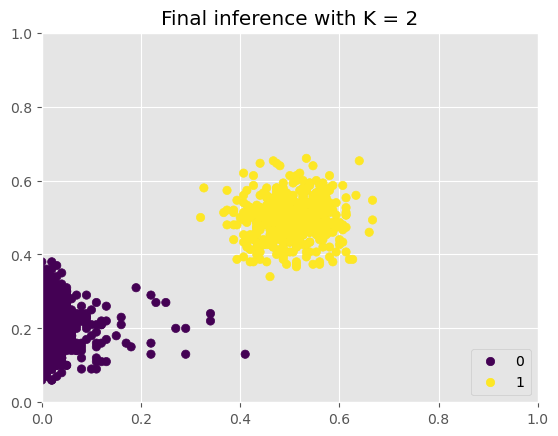

Selected number of clusters is:  2


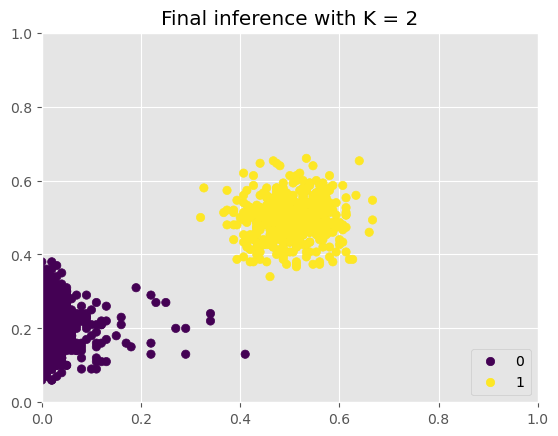

In [115]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [2], seed = 15, lr = 0.001)

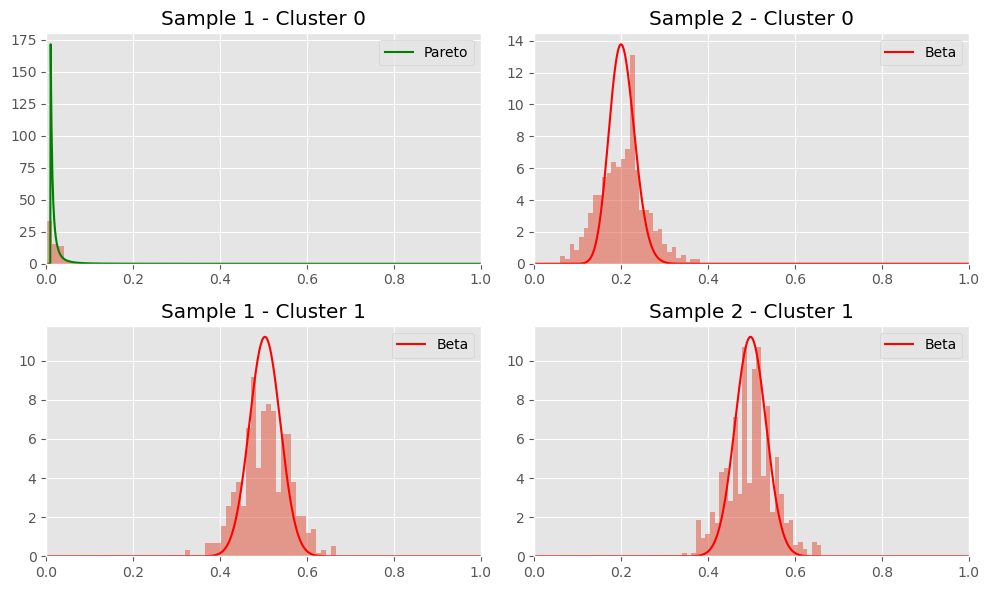

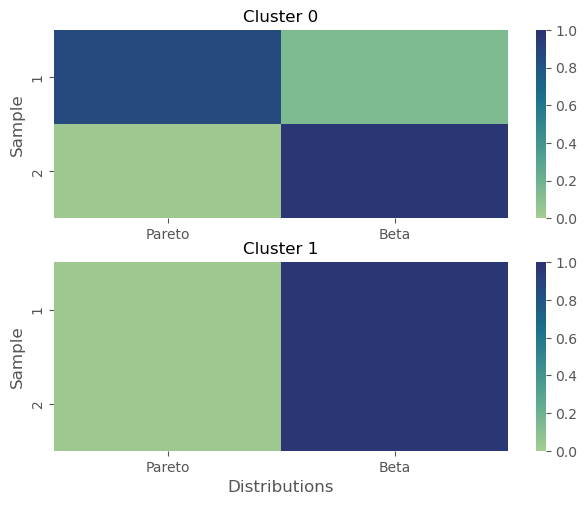

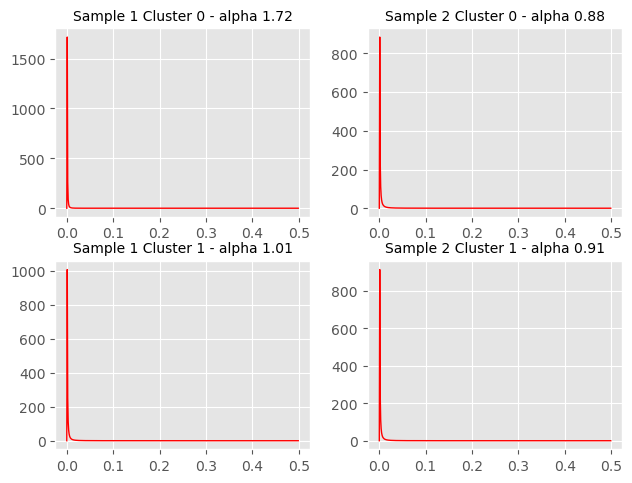

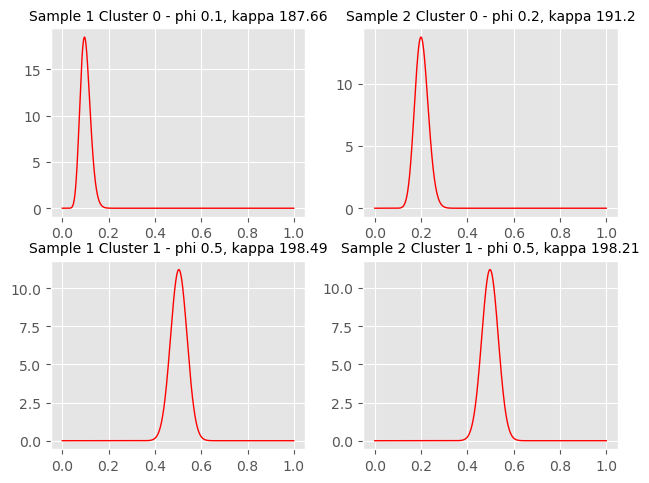

In [116]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [117]:
final_mb.params

{'weights_param': tensor([0.6645, 0.3355], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.7159, 0.8848],
         [1.0071, 0.9138]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.2024],
         [0.5030, 0.4973]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[187.6570, 191.2007],
         [198.4917, 198.2098]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8665, 0.1335],
          [0.0297, 0.9703]],
 
         [[0.0301, 0.9699],
          [0.0292, 0.9708]]], grad_fn=<DivBackward0>),
 'responsib': tensor([[9.9988e-01, 9.9968e-01, 9.9983e-01,  ..., 5.4628e-03, 3.1375e-03,
          3.5701e-03],
         [1.1965e-04, 3.2416e-04, 1.6587e-04,  ..., 9.9454e-01, 9.9686e-01,
          9.9643e-01]], grad_fn=<CopySlices>),
 'cluster_assignments': tensor([0, 0, 0,  ..., 1, 1, 1])}

In [118]:
sample = 1
d = sample-1
k = 0
data_NV = NV1[:,0]
data_DP = DP1[:,0]
data_VAF = data_NV/data_DP + 1e-3
alpha = final_mb.params["alpha_pareto_param"][k,d].detach()
phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
print("Phi: ", phi_beta)
print("Kappa: ", kappa_beta)
print("Alpha: ", alpha)
a_beta = phi_beta * kappa_beta
b_beta = (1-phi_beta) * kappa_beta
beta_log = dist.Beta(a_beta, b_beta).log_prob(data_VAF)
# print("Beta log_prob", beta_log)
pareto_log = BoundedPareto(final_mb.pareto_L, alpha, final_mb.pareto_H).log_prob(data_VAF)
# print("Pareto log_prob", pareto_log)

beta_lk_value = beta_lk(data_NV, data_DP, a_beta, b_beta)
print("BetaBin lk: ", beta_lk_value.sum())
pareto_lk_value = pareto_lk(data_NV, data_DP, alpha) # return a tensor of shape data_NV.shape[0]
print("ParetoBin lk: ", pareto_lk_value.sum())


Phi:  tensor(0.1000)
Kappa:  tensor(187.6570)
Alpha:  tensor(1.7159)
BetaBin lk:  tensor(-5655.9375)
ParetoBin lk:  tensor(-4896.2451)


### 5 beta-pareto components

In [3]:
N1 = 100
N2 = 200
N3 = 100
N4 = 100
N5 = 100
seed = 123
# Component 1
alpha_pareto = 1.2
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 100
phi_beta_y = 1e-10
k_beta_y= 100
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 0.3
k_beta_x = 150
phi_beta_y = 1e-10
k_beta_y= 150
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,1] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# COmponent 5
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n5=150
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)

torch.Size([600, 2])
torch.Size([600, 2])


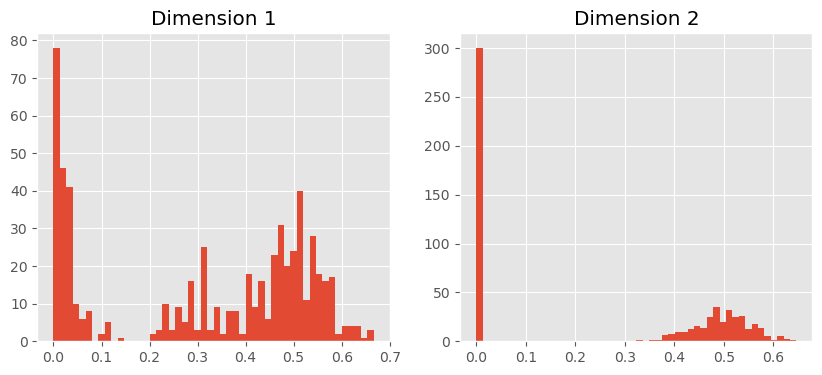

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [5]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))

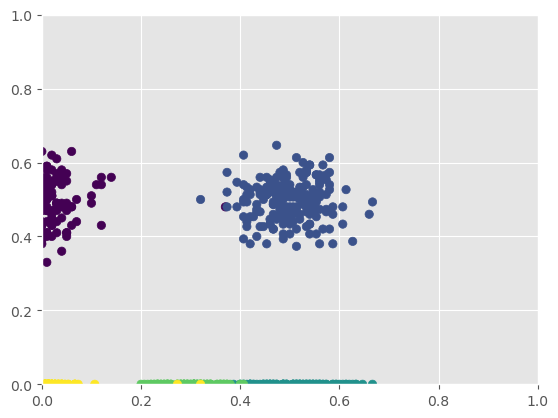

In [6]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K = 5 AND SEED = 39
NV = 0 before: tensor(334)
NV = 0 after: tensor(0)
Iteration 0: Loss = 3102852.917240143
weights_param tensor([0.3359, 0.1581, 0.1648, 0.1631, 0.1781], dtype=torch.float64,
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9992, 1.0008],
        [0.9995, 1.0008],
        [0.9991, 0.9999],
        [0.9992, 1.0007],
        [0.9993, 1.0007]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5005, 0.4978],
        [0.5197, 0.1000],
        [0.1000, 0.4931],
        [0.1000, 0.1000],
        [0.3046, 0.1000]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6453, 200.2707],
        [199.6359, 199.9457],
        [199.7034, 199.9436],
        [199.6220, 199.9468],
        [200.1179, 199.6514]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3990, 0.6010],
         [0.3992, 0.6008]],

        [[0.3993, 0.6007],
         [0.6010, 0.3990]],

        [[0.4010, 0.5990],
         [0.3990, 0.6010]],

        [[0.4007, 0.5993],
         [0.6009, 0.3991]],


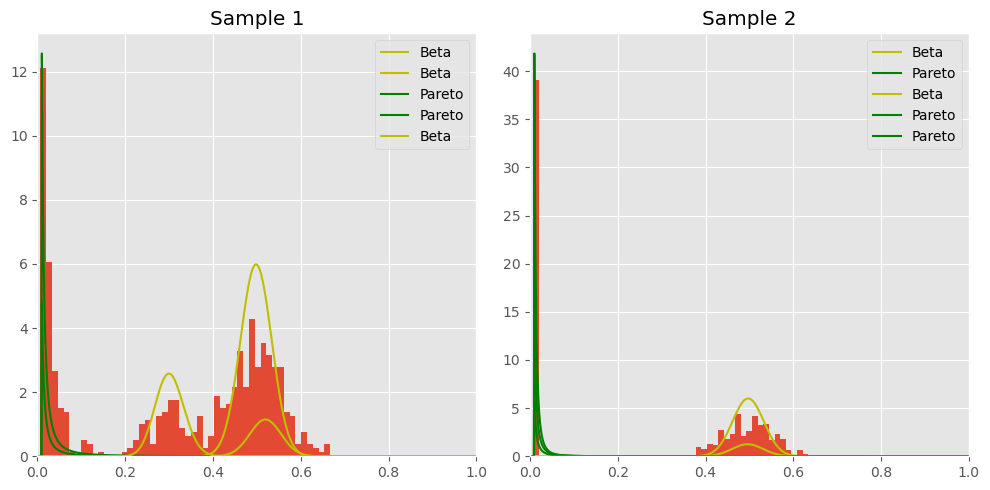

bic:  tensor(34732.7891, grad_fn=<RsubBackward1>)


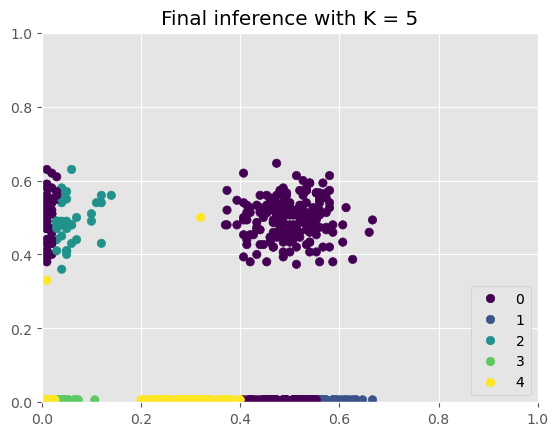

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2843546.9181022644
weights_param tensor([0.3357, 0.1581, 0.1647, 0.1630, 0.1785], dtype=torch.float64,
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9992, 1.0009],
        [0.9992, 1.0007],
        [0.9992, 1.0008],
        [0.9999, 1.0001],
        [0.9992, 1.0008]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5029, 0.4959],
        [0.5190, 0.1000],
        [0.1000, 0.4999],
        [0.1000, 0.1000],
        [0.3049, 0.1000]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6040, 200.3639],
        [199.6134, 199.9450],
        [199.6254, 199.9468],
        [199.9445, 199.9462],
        [200.3904, 199.9395]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3991, 0.6009],
         [0.3991, 0.6009]],

        [[0.3997, 0.6003],
         [0.6009, 0.3991]],

        [[0.4007, 0.5993],
         [0.3997, 0.6003]],

        [[0.4008, 0.5992],
         [0.6008, 0.3992]],



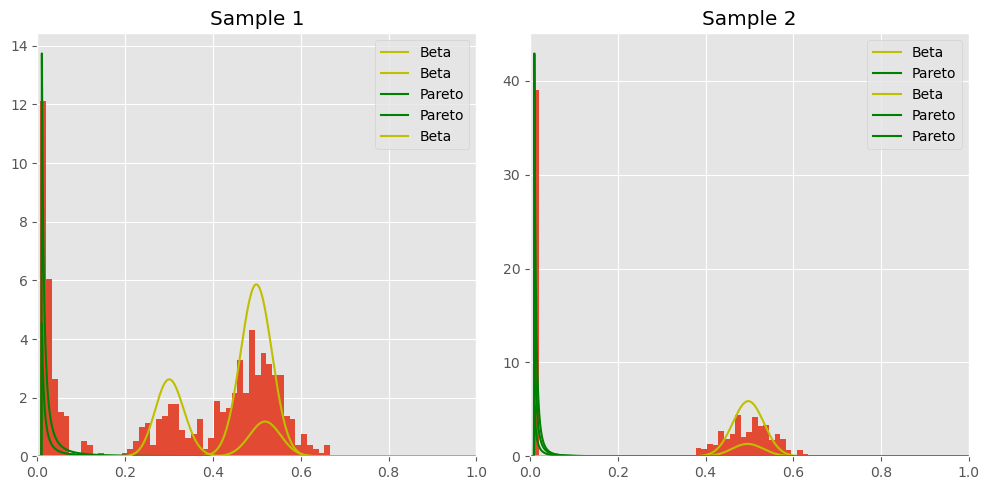

bic:  tensor(34732.4453, grad_fn=<RsubBackward1>)


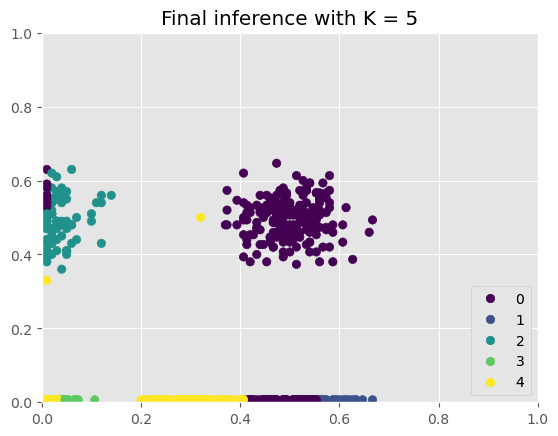

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 3479010.170964241
weights_param tensor([0.3359, 0.1581, 0.1648, 0.1632, 0.1781], dtype=torch.float64,
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9998, 1.0008],
        [1.0007, 1.0007],
        [0.9998, 1.0007],
        [0.9993, 0.9999],
        [1.0008, 1.0007]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5022, 0.4944],
        [0.5153, 0.1000],
        [0.1000, 0.4983],
        [0.1000, 0.1000],
        [0.3090, 0.1000]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6149, 200.2974],
        [199.7078, 199.6211],
        [199.7072, 200.0546],
        [199.6515, 199.9452],
        [200.3936, 199.6509]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3991, 0.6009],
         [0.3991, 0.6009]],

        [[0.3992, 0.6008],
         [0.6008, 0.3992]],

        [[0.4010, 0.5990],
         [0.3990, 0.6010]],

        [[0.4008, 0.5992],
         [0.5999, 0.4001]],

 

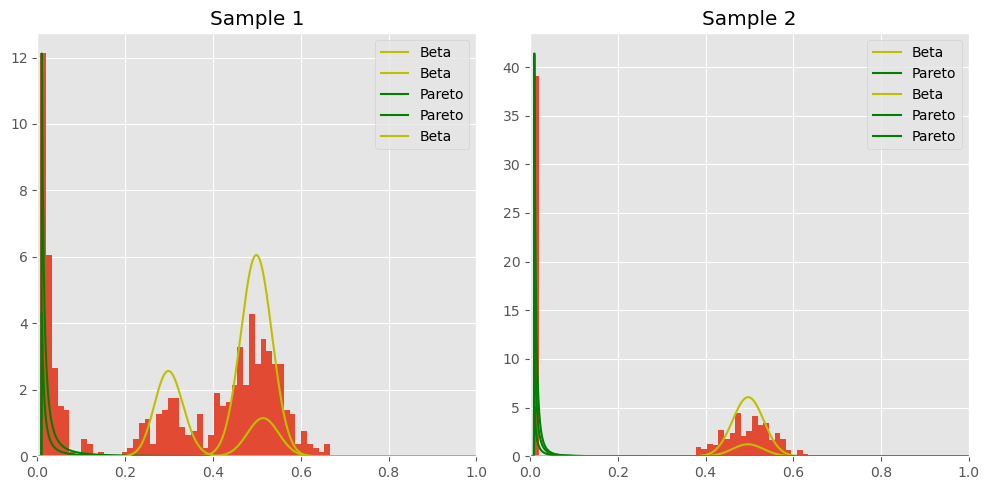

bic:  tensor(34732.9922, grad_fn=<RsubBackward1>)


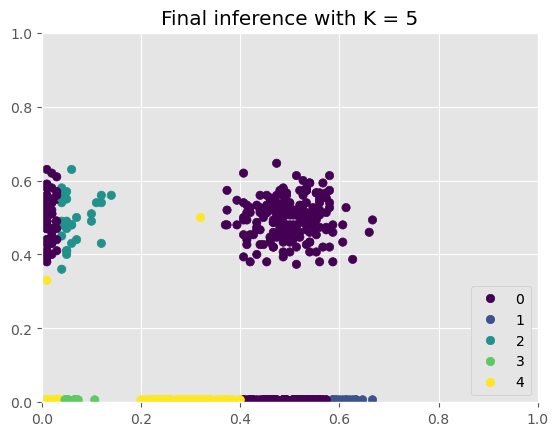

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2737703.666964531
weights_param tensor([0.3354, 0.1579, 0.1652, 0.1629, 0.1785], dtype=torch.float64,
       grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[0.9998, 1.0007],
        [0.9999, 1.0008],
        [1.0007, 1.0007],
        [1.0007, 0.9993],
        [0.9998, 1.0008]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5001, 0.4981],
        [0.5158, 0.1000],
        [0.1000, 0.4944],
        [0.1000, 0.1000],
        [0.3049, 0.1000]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6051, 200.2782],
        [199.6092, 199.6849],
        [199.6583, 199.9242],
        [199.9482, 199.9472],
        [199.6741, 199.9377]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3991, 0.6009],
         [0.3990, 0.6010]],

        [[0.3996, 0.6004],
         [0.5998, 0.4002]],

        [[0.4010, 0.5990],
         [0.3993, 0.6007]],

        [[0.4010, 0.5990],
         [0.6002, 0.3998]],

 

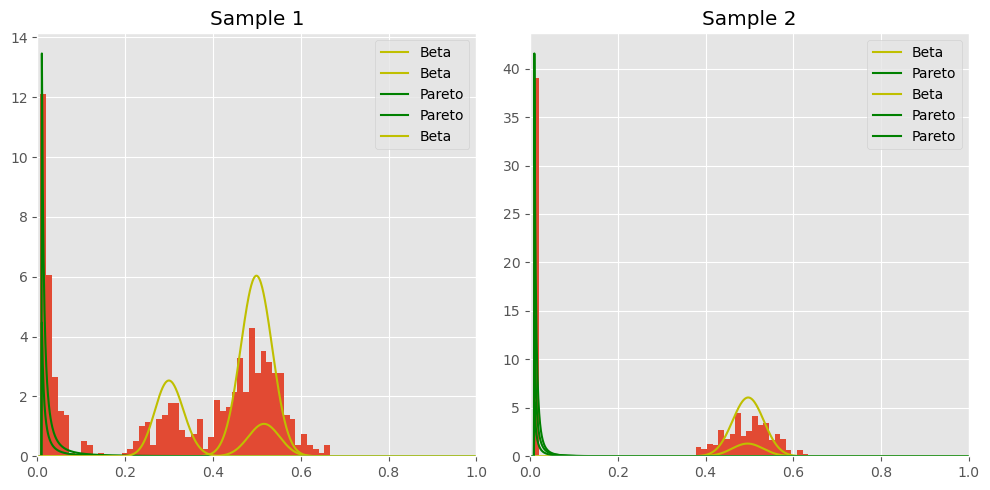

bic:  tensor(34733.5547, grad_fn=<RsubBackward1>)


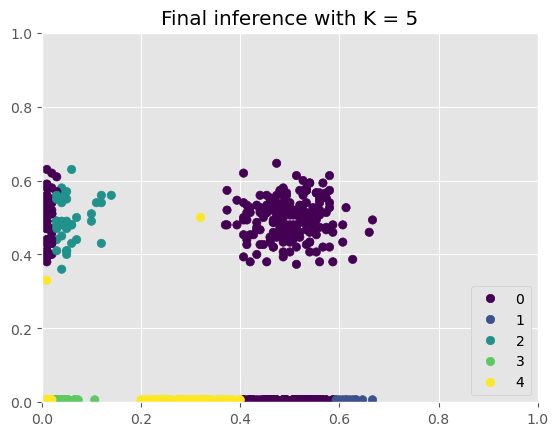

Selected number of clusters is5 with seed 40


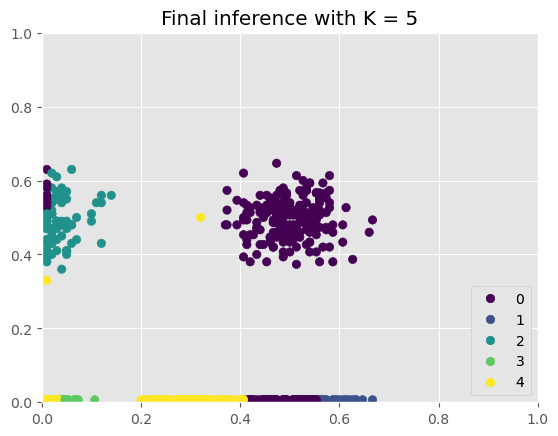

In [8]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [39,40,41,42], lr = 0.001)

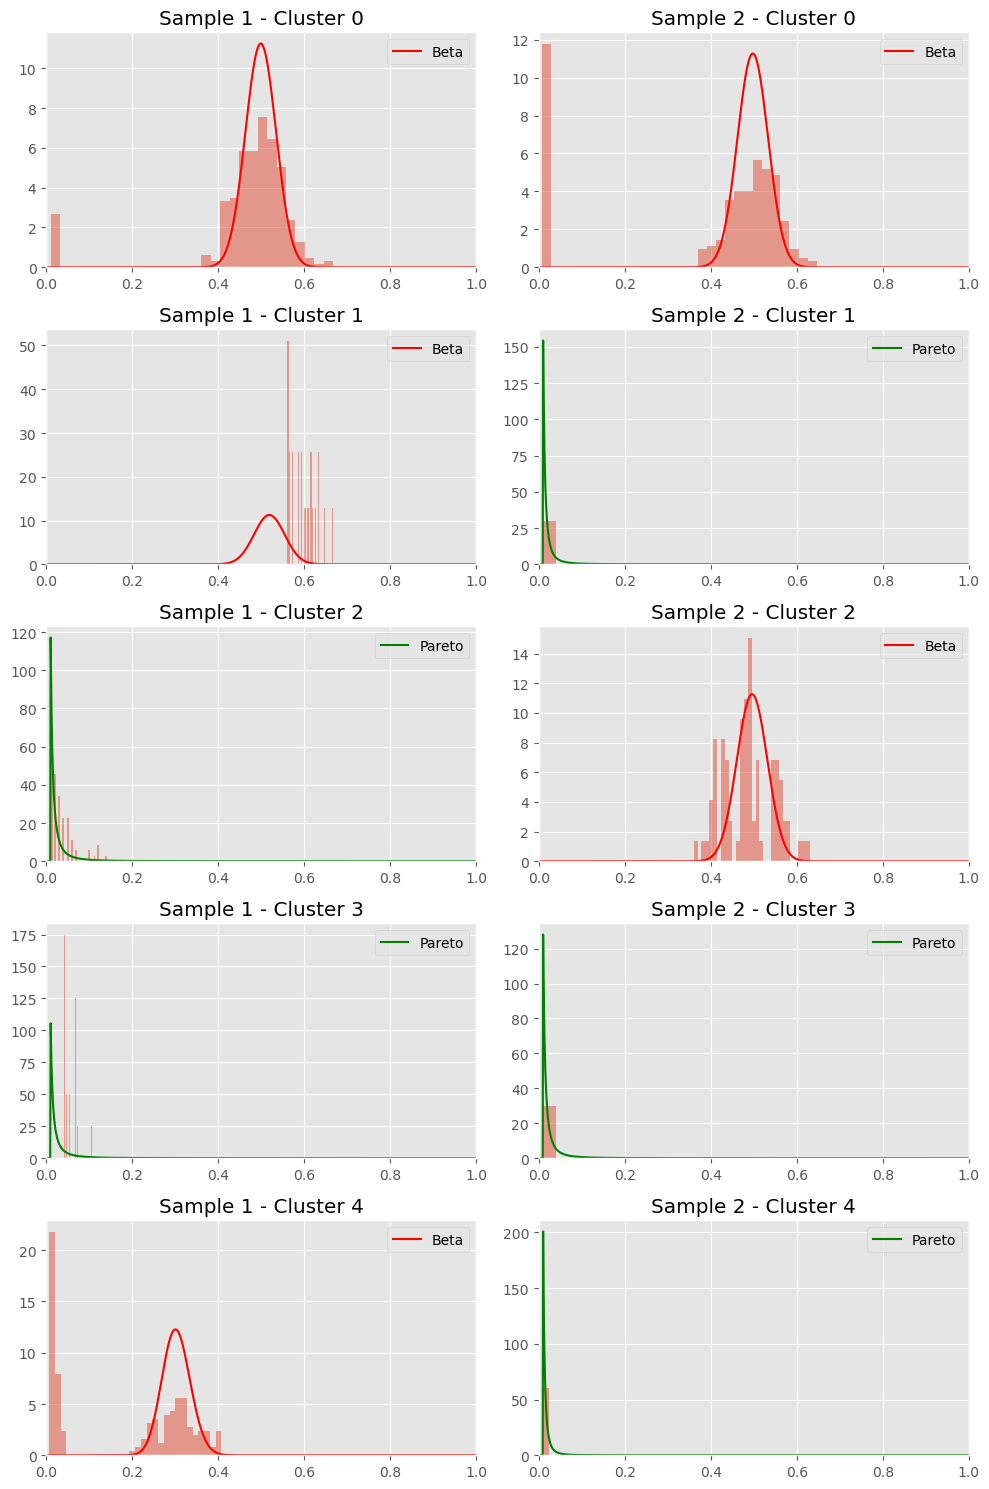

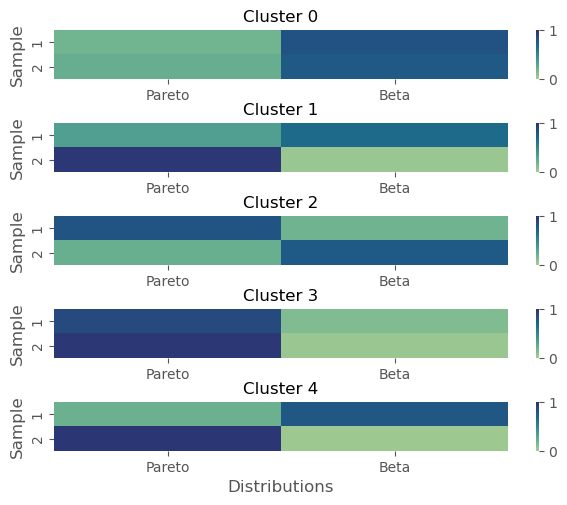

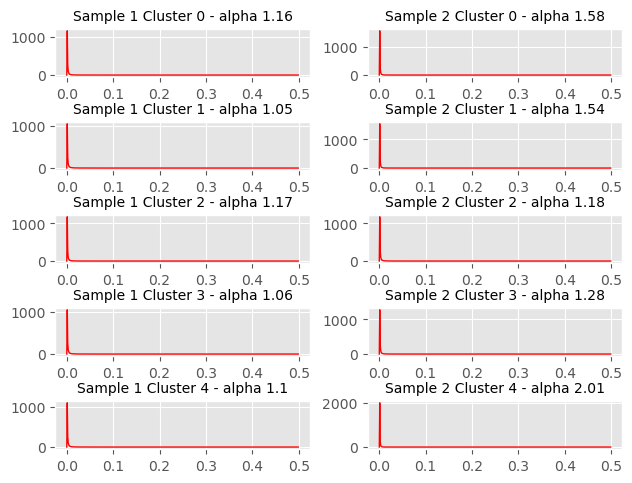

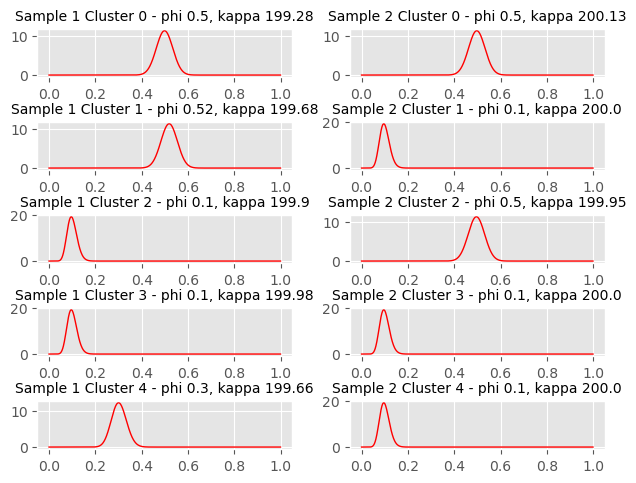

In [9]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

torch.Size([298])
Min vaf tensor(0.0067)


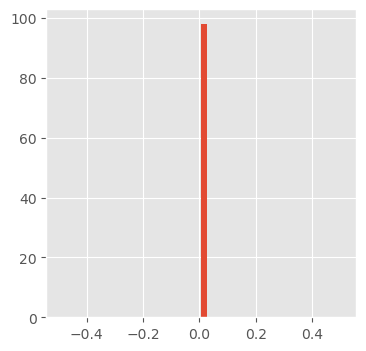

In [30]:
# CHECK LIKELIHOOD CLUSTER 4 SAMPLE 1
s = 2 # sample
k = 0 # cluster
d = s-1
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[labels == k, d]
data_DP = DP[labels == k, d]
data_VAF = data_NV/data_DP
threshold = 0.2
data_VAF1 = data_VAF[data_VAF < threshold] # to check likelihood of data which are greater than 0.1
data_NV1 = data_NV[data_VAF < threshold] # i.e. what happens if data < 0.1 were assigned to a pareto in cluster 1
data_DP1 = data_DP[data_VAF < threshold]
print(data_VAF.shape)
plt.figure(figsize=(4, 4))
plt.hist(data_VAF1.numpy(), bins = 50);
# plt.ylim([0,60])
print("Min vaf", torch.min(data_VAF1))

In [11]:
final_mb.params

{'weights_param': tensor([0.5210, 0.1051, 0.1173, 0.0429, 0.2136], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.1574, 1.5801],
         [1.0512, 1.5441],
         [1.1711, 1.1756],
         [1.0557, 1.2806],
         [1.0992, 2.0088]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4985, 0.4974],
         [0.5183, 0.1000],
         [0.1000, 0.4958],
         [0.1000, 0.1000],
         [0.3021, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[199.2848, 200.1302],
         [199.6805, 199.9988],
         [199.9031, 199.9464],
         [199.9777, 199.9997],
         [199.6645, 199.9998]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.1863, 0.8137],
          [0.2242, 0.7758]],
 
         [[0.3248, 0.6752],
          [0.9607, 0.0393]],
 
         [[0.8064, 0.1936],
          [0.2195, 0.7805]],
 
         [[0.8675, 0.1325],
          [0.9574, 0.0426]],
 
         [[0.2094, 0.7906],
          [0.9708, 0.0292]]], grad_fn=<Di

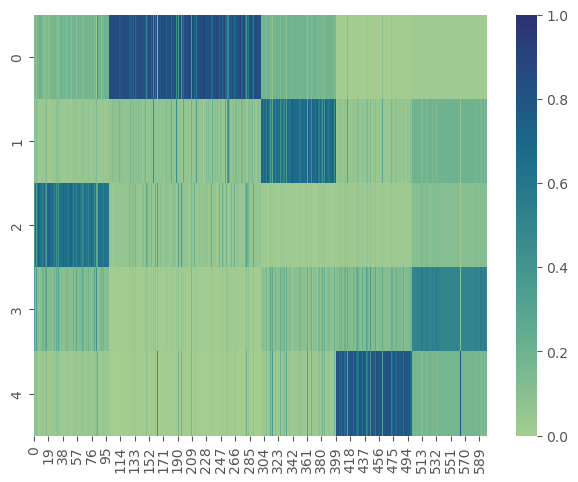

In [19]:
plot_responsib(final_mb)

### rRACES data

In [2]:
NV_r = pd.read_csv("./rRACES_data/NV2.csv")
DP_r = pd.read_csv("./rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


In [3]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0097)
tensor(0.0092)


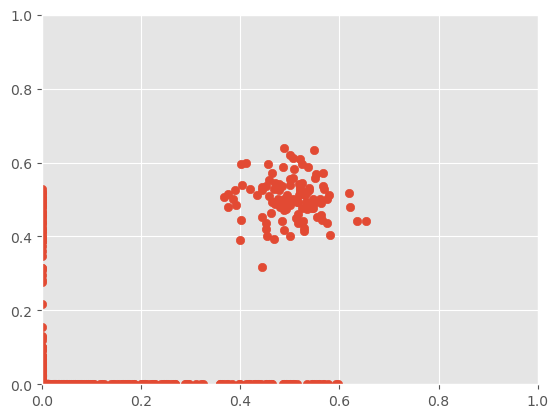

In [4]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

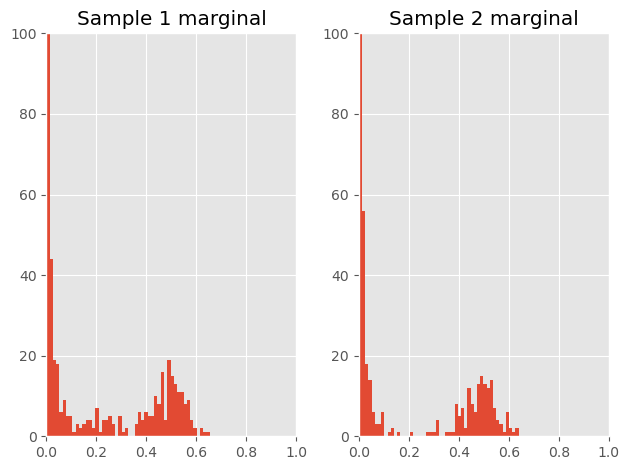

In [5]:
# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])
Cluster Sizes: [ 50 105  46  58 334]
Cluster Sizes Vector: [0.08431703 0.17706577 0.07757167 0.09780776 0.56323777]


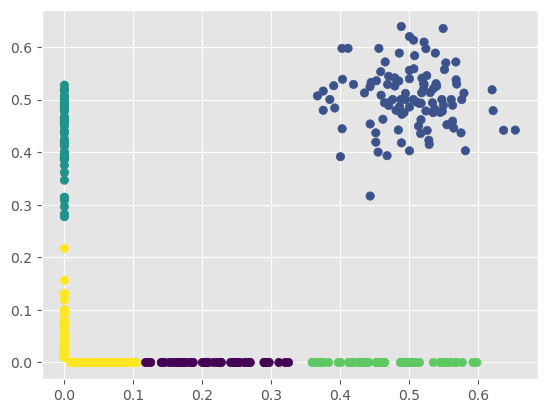

In [7]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters=K, random_state=123, n_init=2).fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

# print(labels.astype(int))
# Compute cluster sizes
cluster_sizes = np.bincount(cluster.astype(int), minlength=K)
print("Cluster Sizes:", cluster_sizes)

# Convert to a 1D vector
cluster_sizes_vector = cluster_sizes.reshape(-1)/np.sum(cluster_sizes.reshape(-1))
print("Cluster Sizes Vector:", cluster_sizes_vector)

RUN WITH K = 5 AND SEED = 39
NV = 0 before: tensor(488)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2123390.1701021194
Iteration 200: Loss = 1971065.9961633682
Iteration 400: Loss = 1953178.076496601
Iteration 600: Loss = 1919517.6344780922
Iteration 800: Loss = 1839060.6242394447
Iteration 1000: Loss = 1963075.5626802444
Iteration 1200: Loss = 2018114.39031744
Iteration 1400: Loss = 1918307.4299488068
Iteration 1600: Loss = 1908243.6865620613
Iteration 1800: Loss = 1823979.2186427116
Iteration 2000: Loss = 1856019.5166583061
Iteration 2200: Loss = 1973147.4147014618
Iteration 2400: Loss = 1849537.8162174225
Iteration 2600: Loss = 1817566.4152684212
Iteration 2800: Loss = 1949865.3915433884


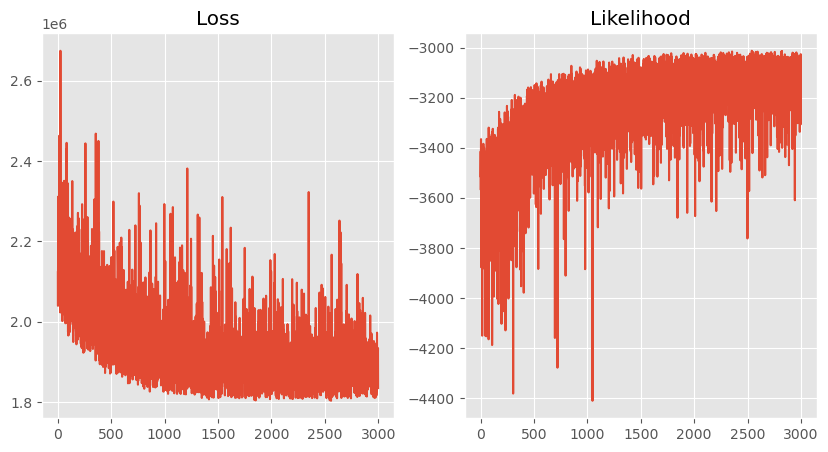

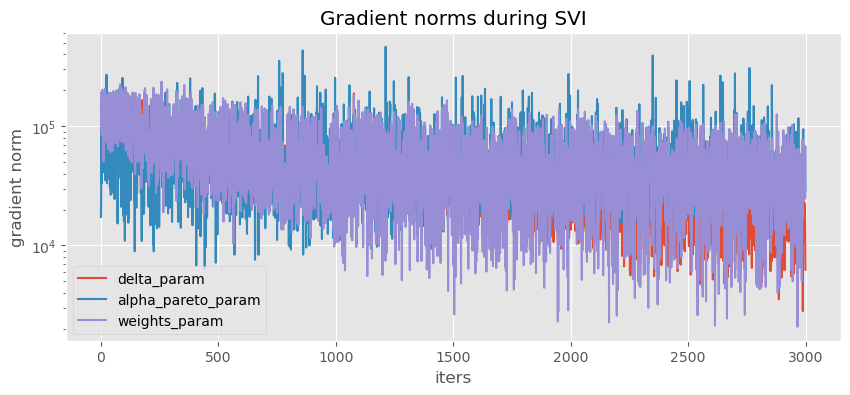

bic:  tensor(32750.2129, grad_fn=<RsubBackward1>)


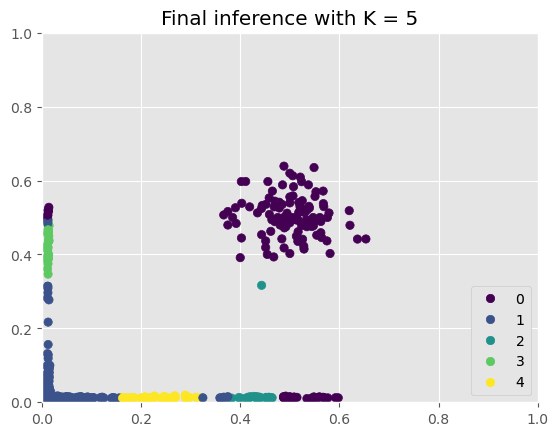

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2056334.9218263626
Iteration 200: Loss = 2091226.4824581146
Iteration 400: Loss = 2239196.568974018
Iteration 600: Loss = 2140833.3254795074
Iteration 800: Loss = 1846131.8622817993
Iteration 1000: Loss = 1870424.9919252396
Iteration 1200: Loss = 1875514.6182599068
Iteration 1400: Loss = 1824491.269560814
Iteration 1600: Loss = 2089199.8782858849
Iteration 1800: Loss = 2045769.1210656166
Iteration 2000: Loss = 1842152.6952295303
Iteration 2200: Loss = 1893594.869460106
Iteration 2400: Loss = 1838362.4227166176
Iteration 2600: Loss = 1959583.6083197594
Iteration 2800: Loss = 1861393.2178835869


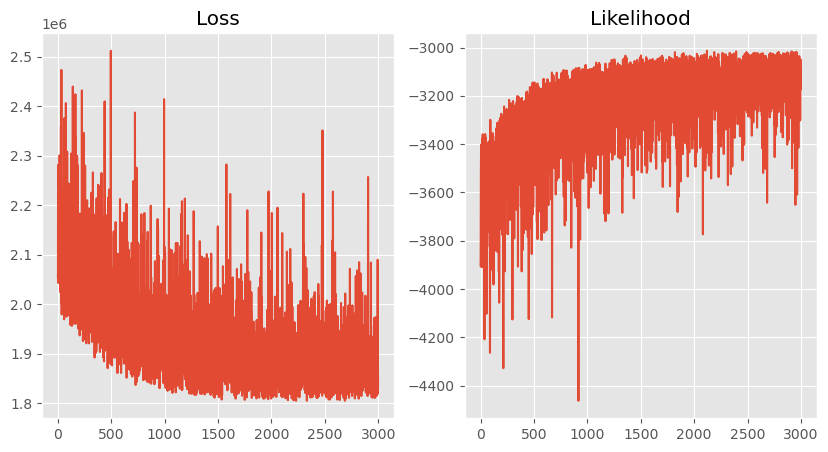

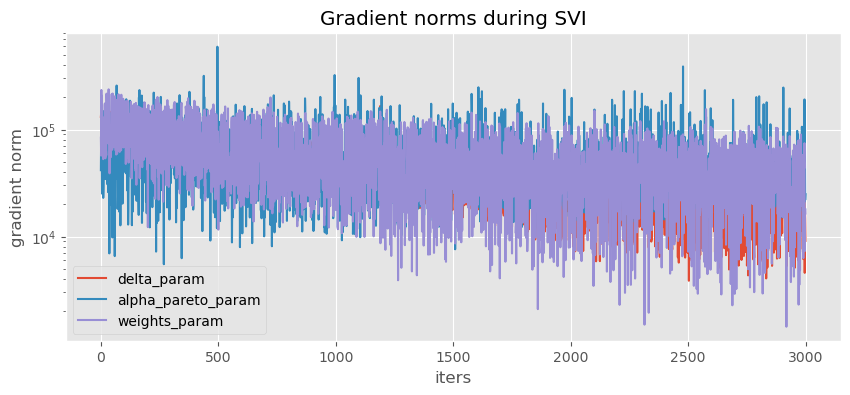

bic:  tensor(32751.5508, grad_fn=<RsubBackward1>)


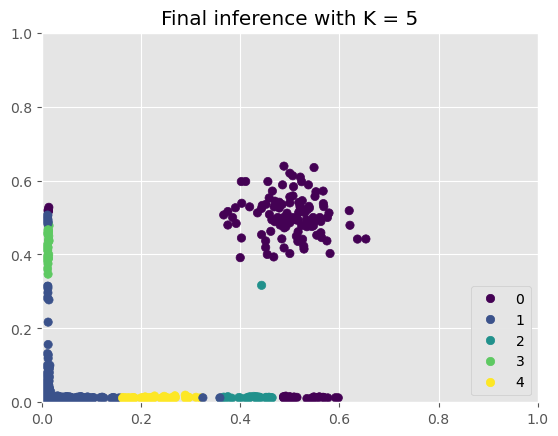

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2456936.422688484
Iteration 200: Loss = 2019338.544295311
Iteration 400: Loss = 1888796.3100919724
Iteration 600: Loss = 1957216.5064868927
Iteration 800: Loss = 1981524.0462760925
Iteration 1000: Loss = 1895218.4172124863
Iteration 1200: Loss = 1820423.7996721268
Iteration 1400: Loss = 1841440.2008371353
Iteration 1600: Loss = 1869971.0626106262
Iteration 1800: Loss = 1850131.0664243698
Iteration 2000: Loss = 1872885.5884332657
Iteration 2200: Loss = 1860433.9912137985
Iteration 2400: Loss = 1838266.704226017
Iteration 2600: Loss = 1817968.0970592499
Iteration 2800: Loss = 1806058.677704811


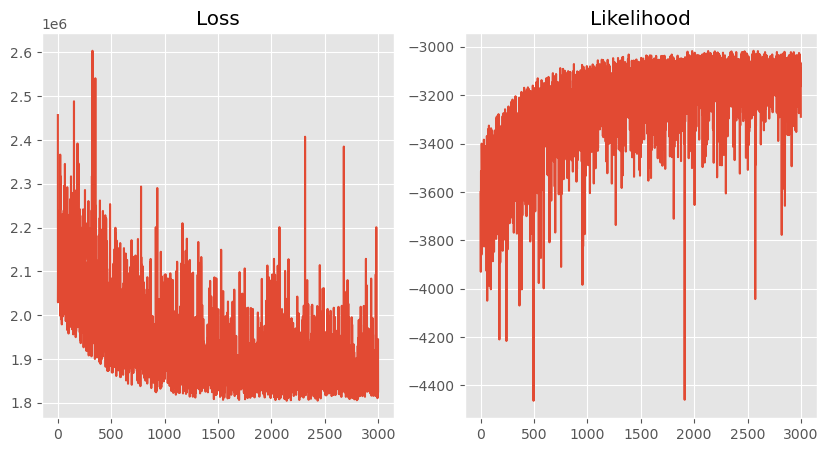

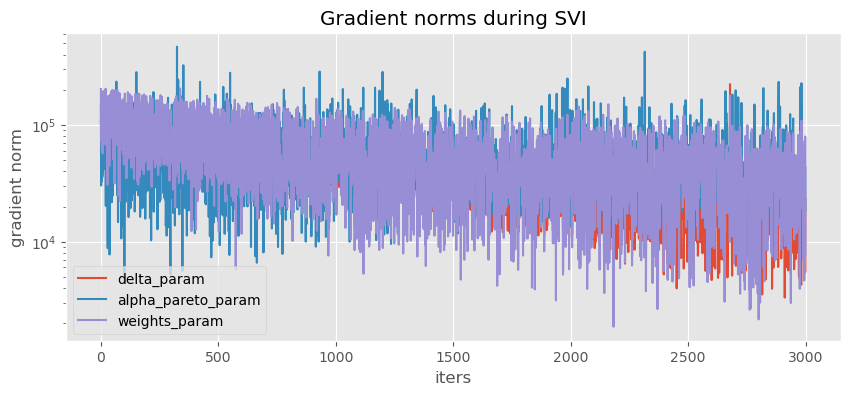

bic:  tensor(32753.1289, grad_fn=<RsubBackward1>)


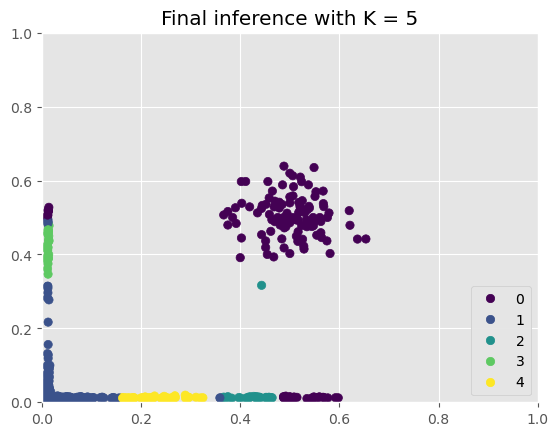

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
Iteration 0: Loss = 2193941.422964096
Iteration 200: Loss = 2021609.2628335953
Iteration 400: Loss = 1930926.5173697472
Iteration 600: Loss = 1971607.4565052986
Iteration 800: Loss = 1884594.4084415436
Iteration 1000: Loss = 1849943.6467251778
Iteration 1200: Loss = 1883147.2615203857
Iteration 1400: Loss = 1870277.6634793282
Iteration 1600: Loss = 1872010.995045662
Iteration 1800: Loss = 1857675.0689849854
Iteration 2000: Loss = 1874382.0444746017
Iteration 2200: Loss = 1946436.2683558464
Iteration 2400: Loss = 1866893.30707407
Iteration 2600: Loss = 1865844.629936695
Iteration 2800: Loss = 1905025.590771675


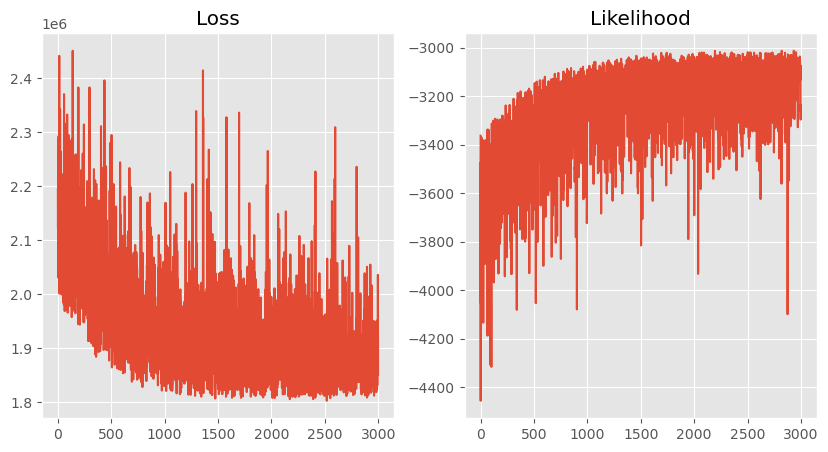

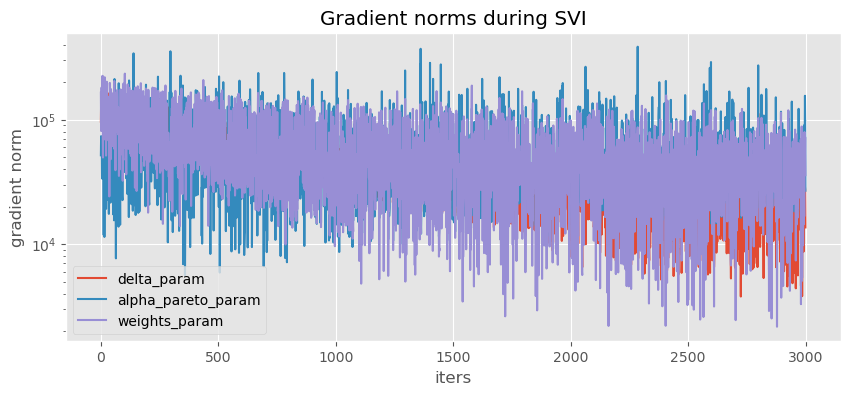

bic:  tensor(32750.6816, grad_fn=<RsubBackward1>)


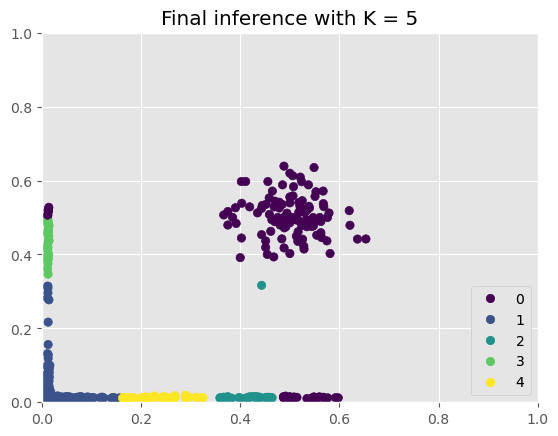

Selected number of clusters is 5 with seed 39


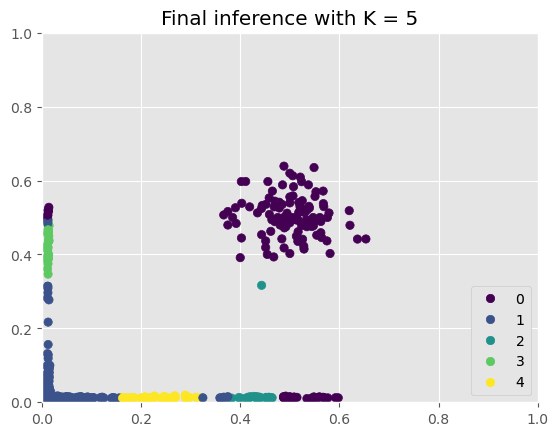

In [8]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [39,40,41,42], lr = 0.001)

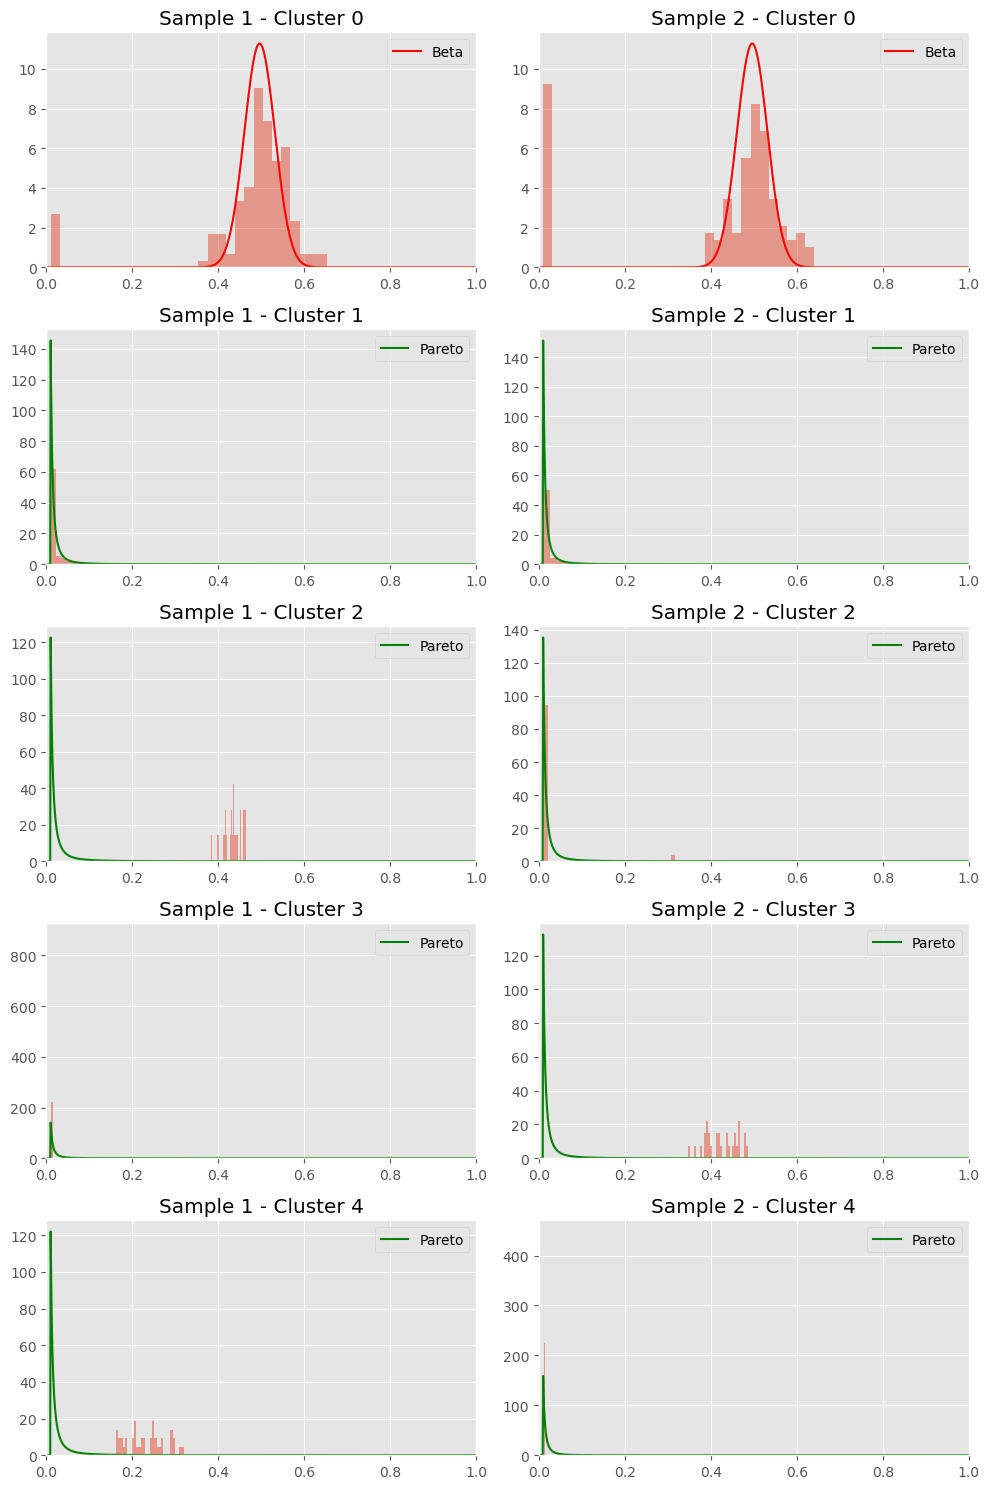

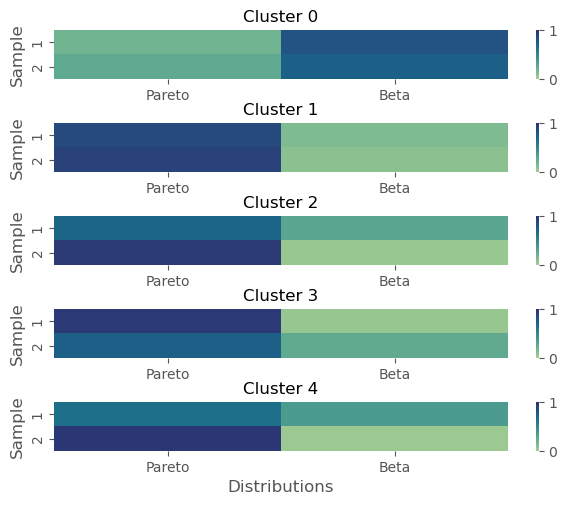

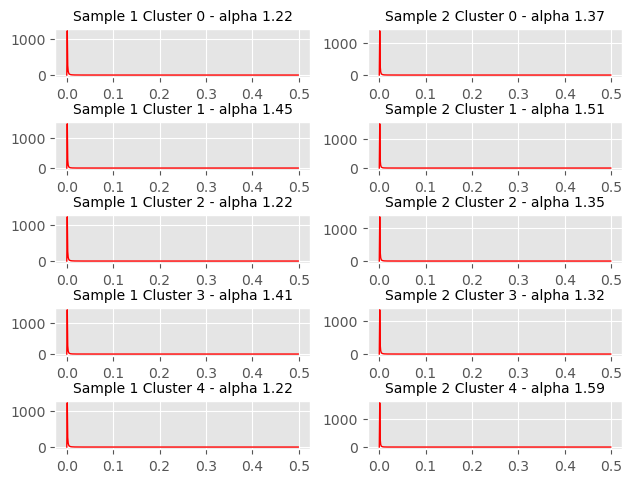

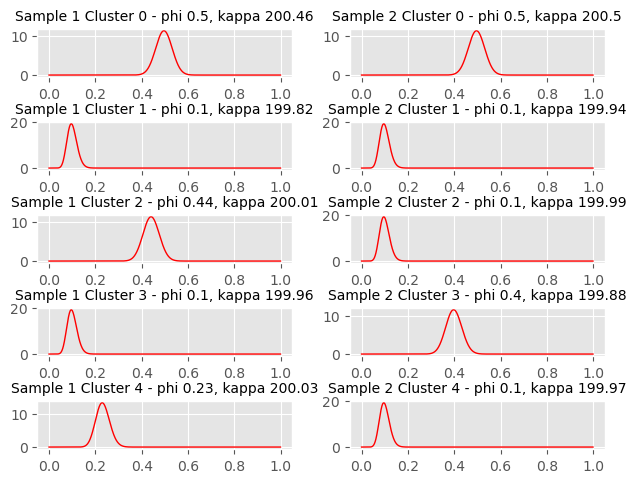

In [9]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

torch.Size([396])
Min vaf tensor(0.)


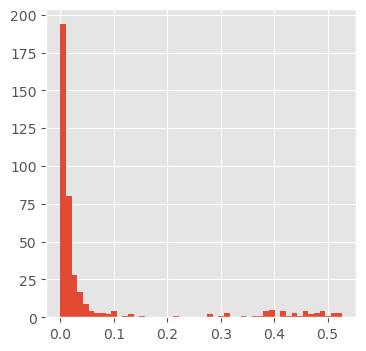

In [107]:
# CHECK LIKELIHOOD CLUSTER 4 SAMPLE 1
s = 2 # sample
k = 3 # cluster
d = s-1
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[labels == k, d]
data_DP = DP[labels == k, d]
data_VAF = data_NV/data_DP
threshold = 0.2
data_VAF1 = data_VAF[data_VAF > threshold] # to check likelihood of data which are greater than 0.1
data_NV1 = data_NV[data_VAF > threshold] # i.e. what happens if data < 0.1 were assigned to a pareto in cluster 1
data_DP1 = data_DP[data_VAF > threshold]
print(data_VAF.shape)
plt.figure(figsize=(4, 4))
plt.hist(data_VAF.numpy(), bins = 50);
# plt.ylim([0,60])
print("Min vaf", torch.min(data_VAF))
# plt.hist(data_VAF.numpy(), bins = 50);
# plt.xlim([0,1])
# x = np.linspace(0.001, 1., 100)
# phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
# kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
# a = phi_beta[k,d] * kappa_beta[k,d]
# b = (1-phi_beta[k,d]) * kappa_beta[k,d]
# pdf = beta.pdf(x, a, b)# * weights[k]
# plt.plot(x, pdf, linewidth=1.5, label='Beta', color='r')
# plt.legend()
# plt.plot(x, pdf, linewidth=1.5, label='Pareto', color='g')
# plt.legend()

In [125]:
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[labels == k, ]
data_DP = DP[labels == k, ]
data_VAF = data_NV/data_DP

In [101]:
vaf.numpy().shape

(593, 2)

In [108]:
labels.shape

(593,)

In [112]:
(labels==k).shape
(np.where(vaf.numpy() > threshold, )[0]).shape

(346,)

In [124]:
vaf = NV/DP

idxs = (vaf.numpy() > threshold)[:,1] & (labels==k)

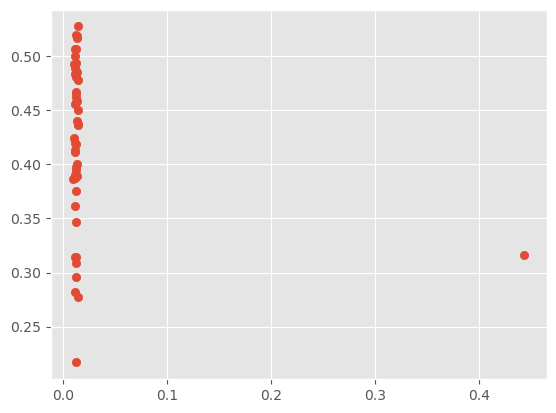

In [126]:
plt.scatter(vaf[idxs,0], vaf[idxs,1])

In [9]:
sns.heatmap(final_mb.params["responsib"][:,idxs].detach().numpy(), vmin=0, vmax=1, cmap="crest")

NameError: name 'idxs' is not defined

In [51]:
data_VAF = data_VAF1
data_NV = data_NV1
data_DP = data_DP1
phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
print("Phi: ", phi_beta)
kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
print("Kappa: ", kappa_beta)
alpha = (final_mb.params["alpha_pareto_param"][k,d]).detach() 
# alpha = torch.tensor(4.)
print("Alpha: ", alpha)
alpha = final_mb.alpha_factor*alpha
a_beta = phi_beta * kappa_beta
b_beta = (1-phi_beta) * kappa_beta
beta_log = dist.Beta(a_beta, b_beta).log_prob(data_VAF)
print("Beta log_prob", beta_log)
pareto_log = BoundedPareto(final_mb.pareto_L, alpha, final_mb.pareto_H).log_prob(data_VAF)
print("Pareto log_prob", pareto_log)

beta_lk_value = beta_lk(data_NV, data_DP, a_beta, b_beta)
print("BetaBin lk: ", beta_lk_value.sum())
pareto_lk_value = pareto_lk(data_NV, data_DP, alpha) # return a tensor of shape data_NV.shape[0]
print("ParetoBin lk: ", pareto_lk_value.sum())

Phi:  tensor(0.4209)
Kappa:  tensor(199.7862)
Alpha:  tensor(1.5799)
Beta log_prob tensor([  2.0759,   1.5875,   2.1696,   2.0321,  -0.0999,   1.8350,  -1.2493,
          2.0764,   2.0321,   1.1097,  -1.4063,   1.6025,   2.2685,   1.8652,
          0.7224,  -4.3840,   0.2751,   2.4336,  -0.5269,   1.9276,  -6.8619,
          1.9951,   2.2678,   2.4158,   0.9723,   0.3145,  -1.4817,   0.1442,
          0.9578,   1.9722,  -2.4885,  -2.1366,   1.7101,   2.3308,  -6.1797,
          2.4061,   0.5404,   2.4263,   0.8346,   1.5691,  -0.5269,   2.2261,
          2.3129,  -2.4885,   2.4345, -18.0504,  -3.0219])
Pareto log_prob tensor([ -9.4908,  -9.3209,  -9.5343,  -9.4722, -10.5177, -10.1601, -10.6526,
        -10.0794,  -9.4722, -10.3285, -10.6689, -10.2225,  -9.5894, -10.1511,
        -10.3971,  -8.3410, -10.4660,  -9.7785, -10.5713, -10.1317,  -8.0625,
         -9.4573,  -9.9904,  -9.7258,  -9.1639, -10.4603, -10.6766,  -8.9941,
        -10.3566,  -9.4484,  -8.5818, -10.7402, -10.1950,  -9.

torch.Size([441])
torch.Size([441])


(0.0, 1.0)

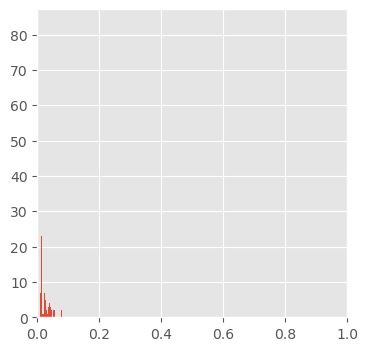

In [122]:
# CHECK LIKELIHOOD CLUSTER 1 SAMPLE 1, taking also some of the points assigned to cluster 4
s = 1 # sample
k = 1 # cluster
d = s-1
labels = final_mb.params['cluster_assignments'].detach().numpy()
data_NV = NV[:,d] + 1e-5
data_DP = DP[:,d]
data_VAF = data_NV/data_DP
threshold = 0.1
data_VAF1 = data_VAF[data_VAF <= threshold]
data_NV1 = data_NV[data_VAF <= threshold]
data_DP1 = data_DP[data_VAF <= threshold]
print(data_VAF.shape)
plt.figure(figsize=(4, 4))
plt.hist(data_VAF1.numpy(), bins = 50);
plt.xlim([0,1])
# plt.hist(data_VAF.numpy(), bins = 50);
# plt.xlim([0,1])

In [123]:
data_VAF = data_VAF1
data_NV = data_NV1
data_DP = data_DP1
phi_beta = final_mb.params["phi_beta_param"][k,d].detach()
print("Phi: ", phi_beta)
kappa_beta = final_mb.params["k_beta_param"][k,d].detach()
print("Kappa: ", kappa_beta)
alpha = (final_mb.params["alpha_pareto_param"][k,d]).detach() 
# alpha = torch.tensor(4.)
print("Alpha: ", alpha)
alpha = final_mb.alpha_factor*alpha
a_beta = phi_beta * kappa_beta
b_beta = (1-phi_beta) * kappa_beta
# beta_log = dist.Beta(a_beta, b_beta).log_prob(data_VAF)
# print("Beta log_prob", beta_log)
# pareto_log = BoundedPareto(final_mb.pareto_L, alpha, final_mb.pareto_H).log_prob(data_VAF)
# print("Pareto log_prob", pareto_log)

beta_lk_value = beta_lk(data_NV, data_DP, a_beta, b_beta)
print("BetaBin lk: ", beta_lk_value.sum())
pareto_lk_value = pareto_lk(data_NV, data_DP, alpha) # return a tensor of shape data_NV.shape[0]
print("ParetoBin lk: ", pareto_lk_value.sum())

Phi:  tensor(0.0381)
Kappa:  tensor(199.1076)
Alpha:  tensor(1.2539)
BetaBin lk:  tensor(-476.1728)
ParetoBin lk:  tensor(-819.5447)


In [10]:
final_mb.params

{'weights_param': tensor([0.2858, 0.2263, 0.1457, 0.1628, 0.1793], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.2185, 1.3659],
         [1.4535, 1.5118],
         [1.2245, 1.3529],
         [1.4095, 1.3246],
         [1.2203, 1.5891]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4959, 0.4961],
         [0.1000, 0.1000],
         [0.4409, 0.1000],
         [0.1000, 0.3985],
         [0.2321, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[200.4634, 200.5038],
         [199.8249, 199.9449],
         [200.0119, 199.9886],
         [199.9618, 199.8826],
         [200.0334, 199.9723]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.1881, 0.8119],
          [0.2650, 0.7350]],
 
         [[0.8660, 0.1340],
          [0.9093, 0.0907]],
 
         [[0.7184, 0.2816],
          [0.9548, 0.0452]],
 
         [[0.9495, 0.0505],
          [0.7425, 0.2575]],
 
         [[0.6452, 0.3548],
          [0.9649, 0.0351]]], grad_fn=<Di

### rRACES longitudinal data

In [3]:
NV_r = pd.read_csv("./rRACES_data/NV_long.csv")
DP_r = pd.read_csv("./rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


In [4]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0094)
tensor(0.0095)


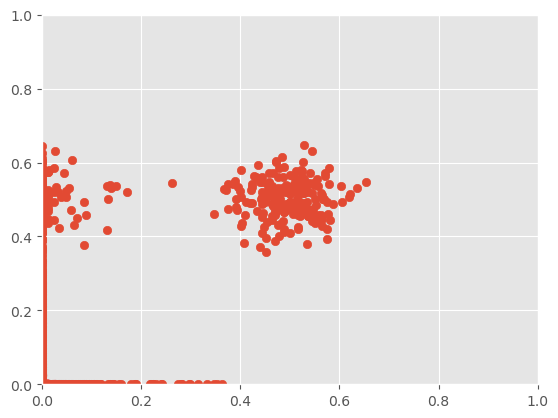

In [5]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

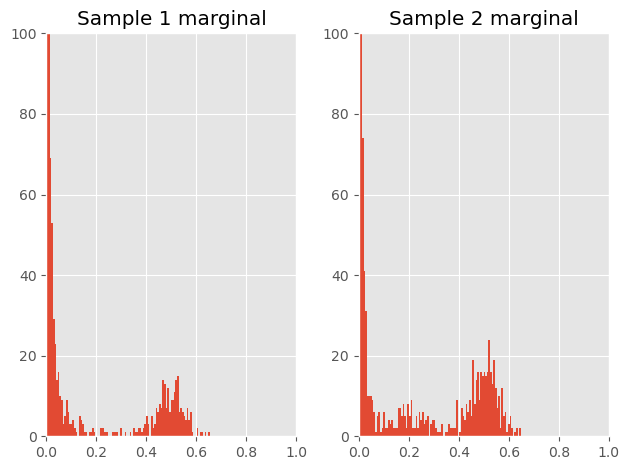

In [6]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.4901e-08],
        [2.2352e-08, 2.1557e-01]])


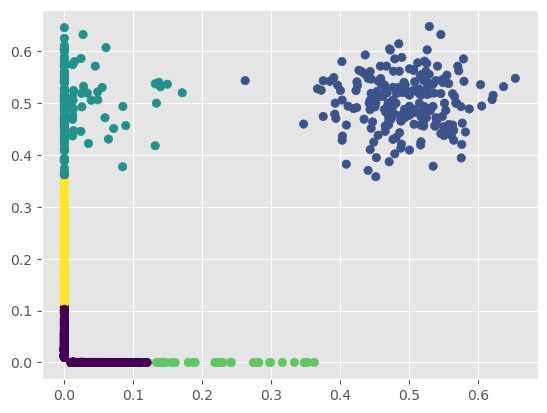

In [169]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

RUN WITH K =  5
NV = 0 before: tensor(965)
NV = 0 after: tensor(0)
Beta:  tensor([[3.5705, 2.4209],
        [3.8959, 2.6066],
        [2.4203, 2.4133],
        [3.6371, 3.7343],
        [2.5952, 3.4698]])
Pareto:  tensor([[ 2.7650, -3.1998],
        [ 4.1027, -1.5503],
        [-3.1930, -3.2300],
        [ 3.1917,  3.3377],
        [-1.6583,  4.1165]])
Iteration 0: Loss = 9464382.0
weights_param tensor([0.1210, 0.0027, 0.6828, 0.1264, 0.0671], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0072, 1.0067],
        [0.9989, 0.9925],
        [1.0085, 0.9988],
        [0.9988, 0.9988],
        [1.0076, 1.0078]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.1000, 0.4925],
        [0.1000, 0.2163],
        [0.4904, 0.5067],
        [0.1000, 0.1000],
        [0.2337, 0.1000]], grad_fn=<AddBackward0>)
k_beta_param tensor([[196.6669, 196.0593],
        [199.4135, 200.9383],
        [202.8029, 203.6523],
        [196.8260, 196.0418],
        [200.5673, 196.1699]], grad_fn=<AddBackward

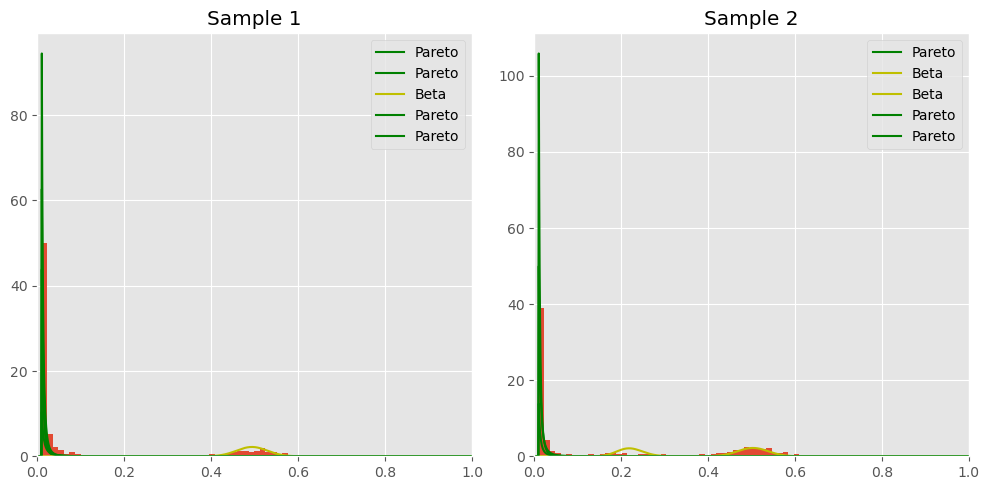

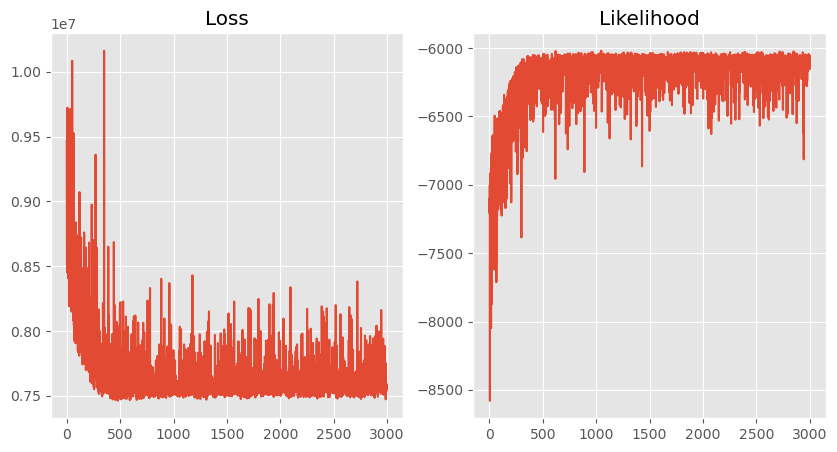

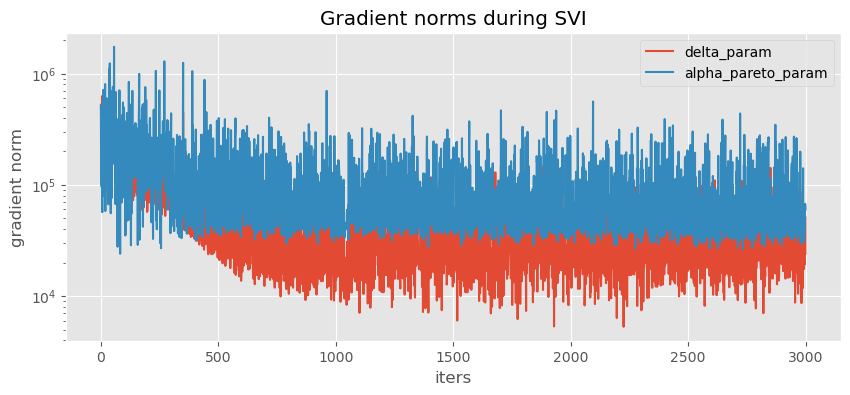

bic:  tensor(72509.6328, grad_fn=<RsubBackward1>)


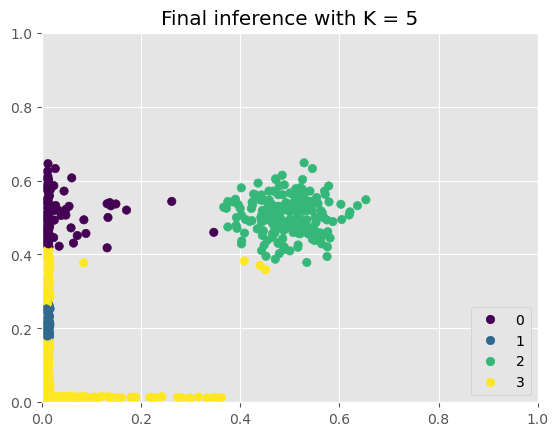

Selected number of clusters is:  5


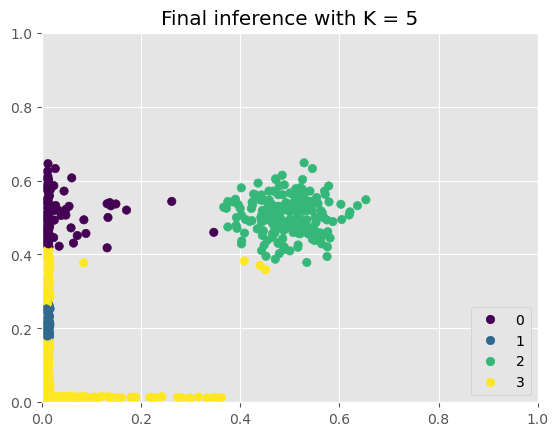

In [7]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = 40, lr = 0.01)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


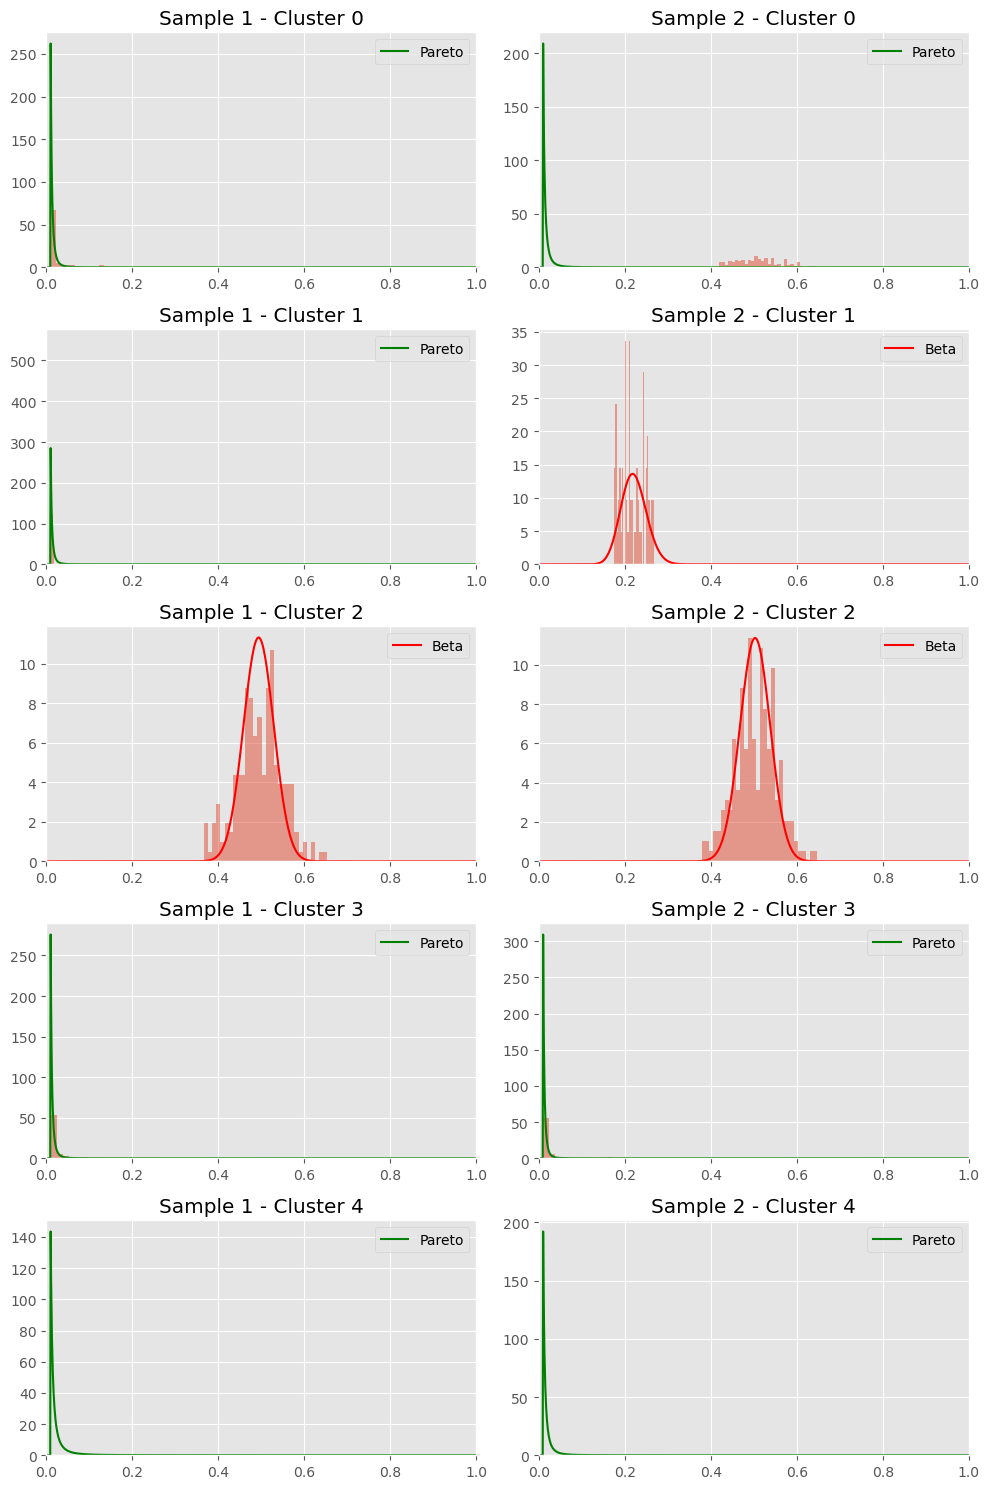

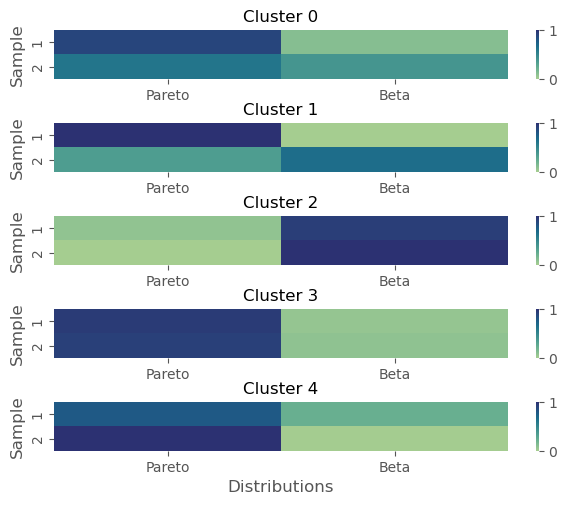

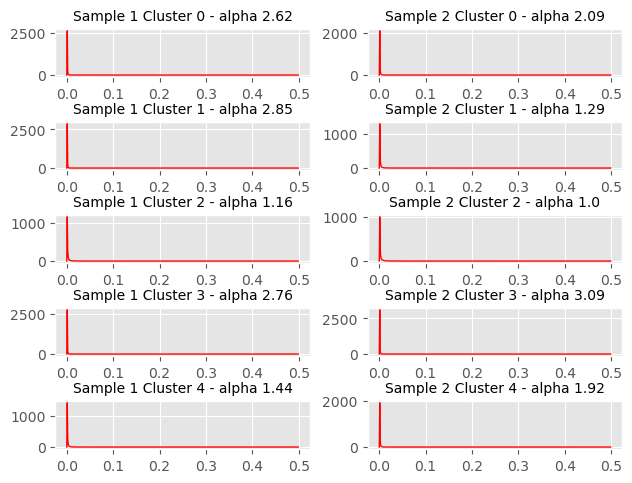

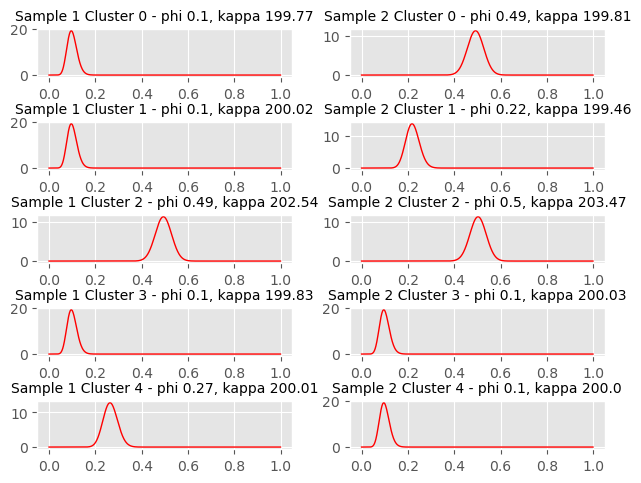

In [8]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [172]:
final_mb.params

{'weights_param': tensor([0.3071, 0.1860, 0.2437, 0.1683, 0.0950], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[3.0326, 0.9933],
         [0.7754, 0.9997],
         [0.9016, 2.1398],
         [1.0052, 1.1061],
         [1.4918, 0.9834]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0884, 0.0100],
         [0.4926, 0.5028],
         [0.0100, 0.4891],
         [0.0101, 0.1968],
         [0.2614, 0.0100]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[199.6583, 195.4381],
         [201.6195, 203.1891],
         [191.4039, 199.3433],
         [196.0397, 196.6714],
         [199.8164, 197.5117]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[8.7381e-01, 1.2619e-01],
          [2.0961e-03, 9.9790e-01]],
 
         [[3.4440e-02, 9.6556e-01],
          [7.1143e-04, 9.9929e-01]],
 
         [[1.9937e-02, 9.8006e-01],
          [5.7424e-01, 4.2576e-01]],
 
         [[2.8251e-03, 9.9717e-01],
          [3.1316e-01, 6.8684e-01]],
 
         [[8.2621e-01, 1.7379e-01]

### Smaller lr

RUN WITH K =  5
Beta:  tensor([[  -3.9368,    3.8052],
        [   1.6349,    2.1802],
        [   3.2540,    1.5370],
        [-142.6215,    2.2635],
        [   2.2309,   -7.4402]])
Pareto:  tensor([[ 3.8701,  4.2767],
        [-3.1930, -3.2300],
        [ 3.6516, -3.1998],
        [30.0522, -1.5362],
        [-1.6583, 31.4385]])
Iteration 0: Loss = 9680264.0
weights_param tensor([0.1177, 0.0026, 0.6896, 0.1231, 0.0669], grad_fn=<DivBackward0>)
alpha_pareto_param tensor([[1.0008, 1.0008],
        [1.0008, 0.9999],
        [1.0007, 1.0008],
        [1.0008, 1.0008],
        [1.0008, 1.0008]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0609, 0.0100],
        [0.5378, 0.4784],
        [0.0100, 0.5422],
        [0.0591, 0.2415],
        [0.2559, 0.0100]], grad_fn=<AddBackward0>)
k_beta_param tensor([[199.6003, 199.6022],
        [199.6088, 200.3997],
        [199.6044, 199.6003],
        [199.6023, 199.6252],
        [199.6358, 199.6005]], grad_fn=<AddBackward0>)
delta_param tenso

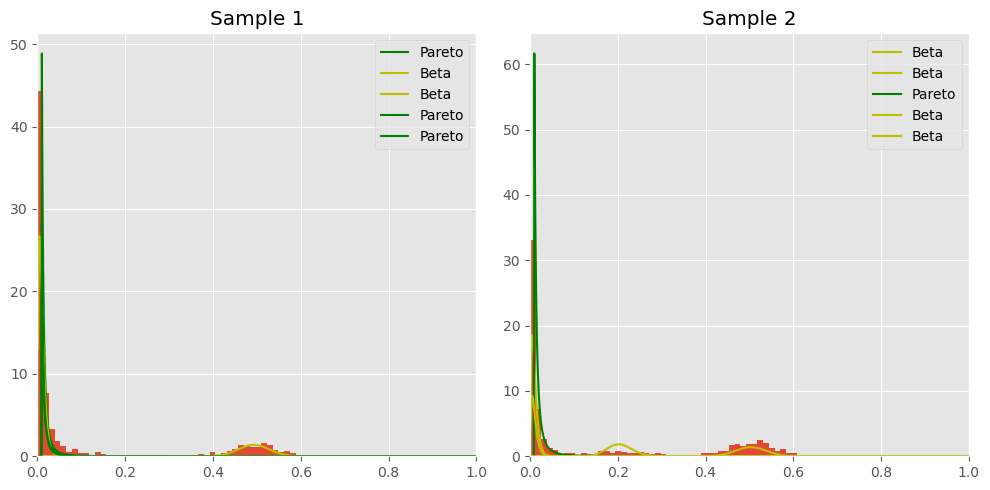

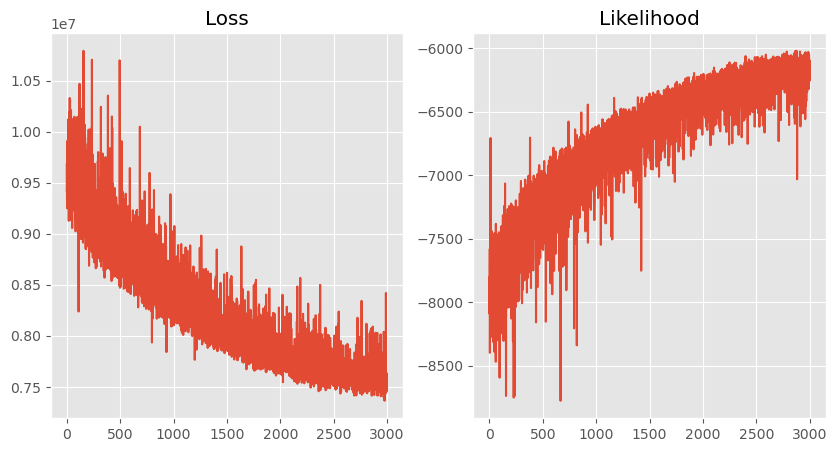

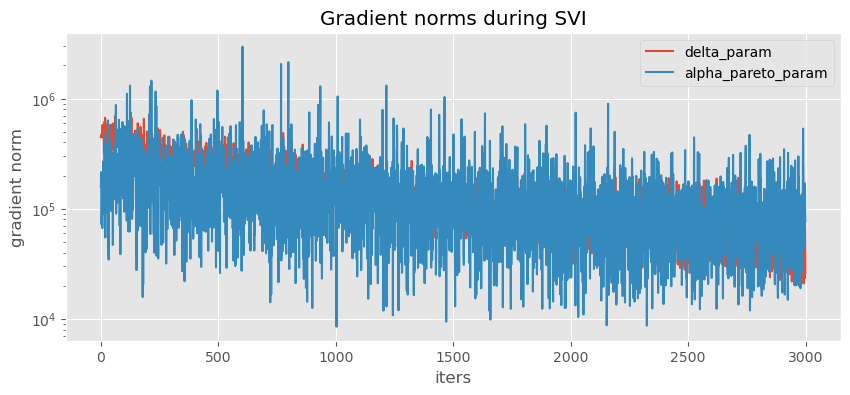

bic:  tensor(67493.2266, grad_fn=<RsubBackward1>)


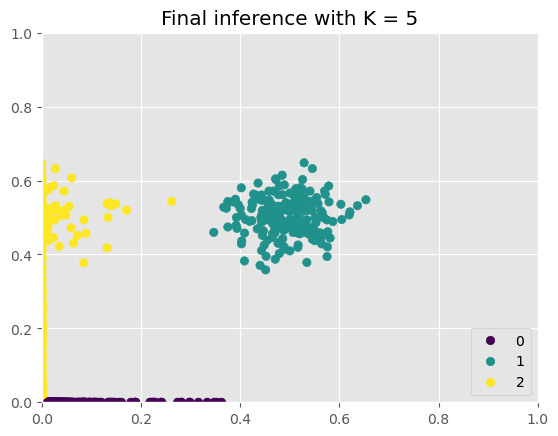

Selected number of clusters is:  5


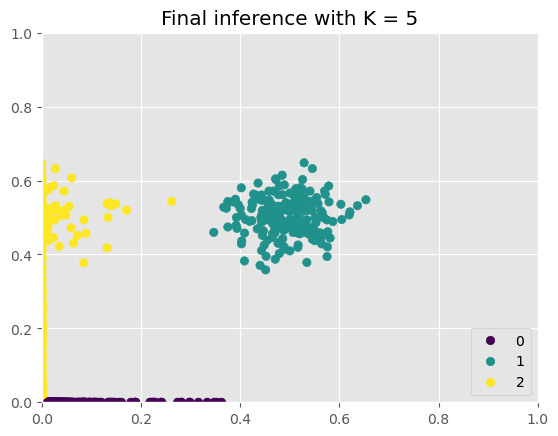

In [173]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = 40, lr = 0.001)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


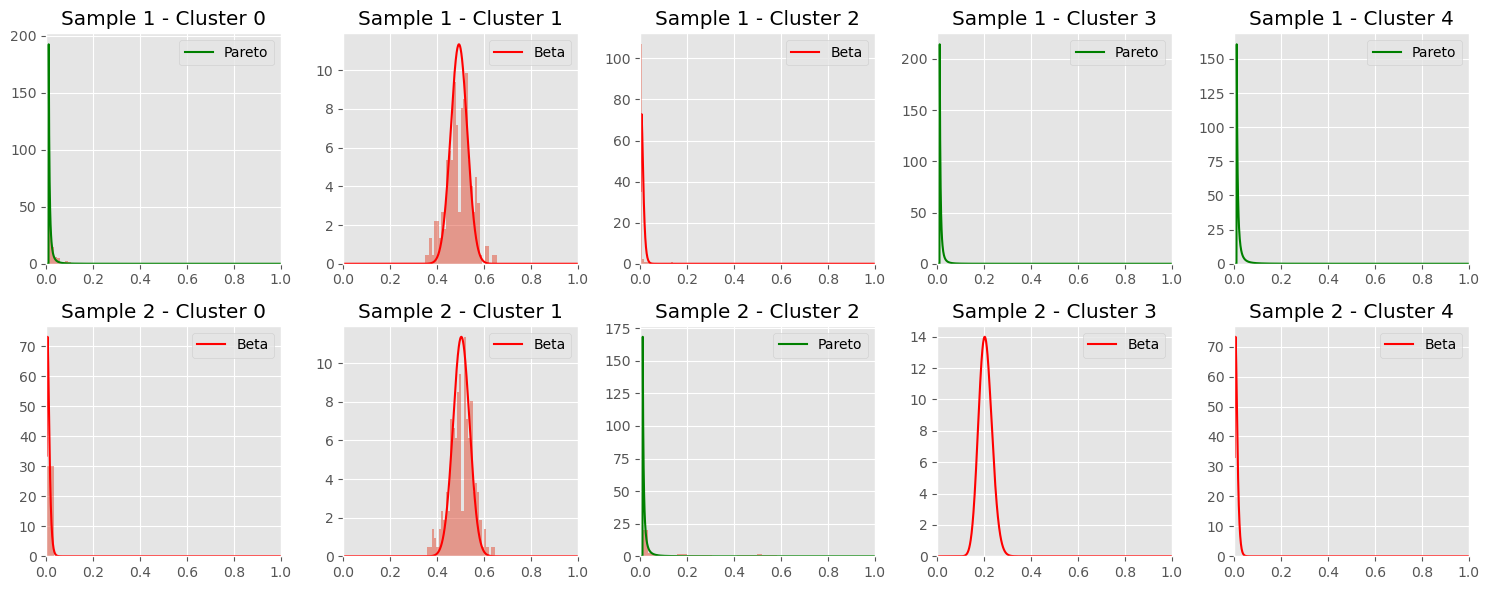

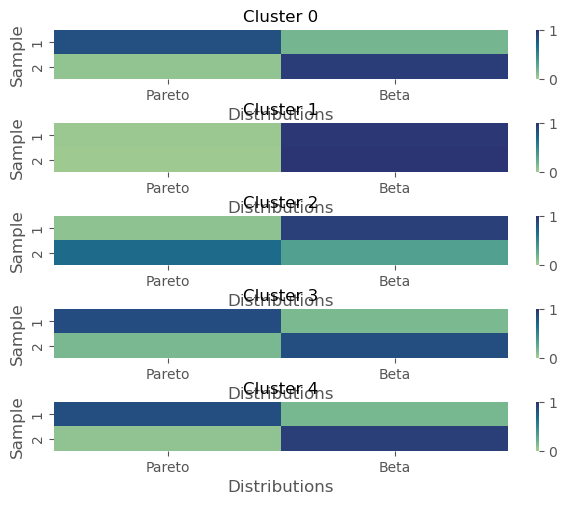

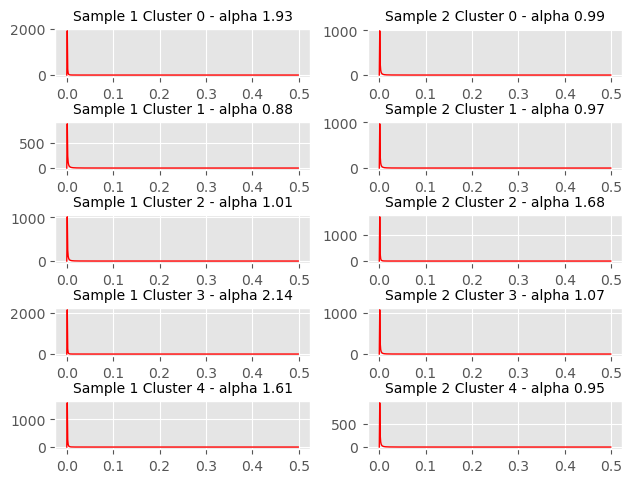

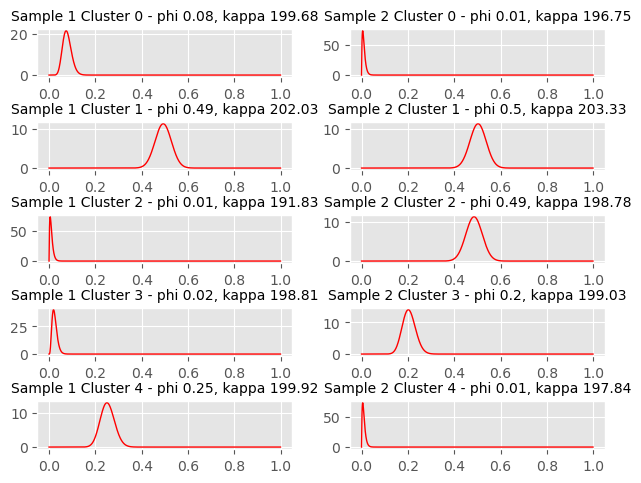

In [174]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [175]:
final_mb.params

{'weights_param': tensor([0.2536, 0.1226, 0.3661, 0.1310, 0.1266], grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.9267, 0.9936],
         [0.8808, 0.9712],
         [1.0114, 1.6840],
         [2.1421, 1.0685],
         [1.6064, 0.9504]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.0780, 0.0100],
         [0.4928, 0.5028],
         [0.0100, 0.4857],
         [0.0242, 0.2049],
         [0.2523, 0.0100]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[199.6809, 196.7453],
         [202.0294, 203.3251],
         [191.8314, 198.7831],
         [198.8055, 199.0325],
         [199.9198, 197.8400]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8290, 0.1710],
          [0.0696, 0.9304]],
 
         [[0.0368, 0.9632],
          [0.0271, 0.9730]],
 
         [[0.0835, 0.9165],
          [0.6773, 0.3227]],
 
         [[0.8502, 0.1498],
          [0.1543, 0.8457]],
 
         [[0.8405, 0.1595],
          [0.0743, 0.9257]]], grad_fn=<DivBackward0>),
 'responsib': t